In [1]:
import os
os.environ['TF_MIN_GPU_MULTIPROCESSOR_COUNT'] = str(1)

In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.95
sess = tf.Session(config=config)

In [3]:
# To support both python 2 and python 3# 
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import imageio
import h5py
import datetime
import random
from functools import partial


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from collections import defaultdict
from random import sample


In [4]:
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [5]:
# to make this notebook's output stable across runs
def reset_graph(seed):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [6]:
def prepare_batch(X_in, y_in, batch_size):
    sampled_i = sample(range(len(X_in)), batch_size)
    images = [X_in[i] for i in sampled_i]
    X_batch = np.stack(images)
    y_batch = np.array([y_in[i] for i in sampled_i], dtype=np.int16)
    return X_batch, y_batch

In [7]:
def normalize_max_inputs(X_in, y_in):
    images = [X_in[i] for i in range(len(X_in))]
    X_batch = np.stack(images)
    y_batch = np.array([y_in[i] for i in range(len(X_in))], dtype=np.int16)
    return X_batch, y_batch

In [8]:
def normalize_max_train(X_in):
    image = [X_in]
    X_train = np.stack(image)
    return X_train

In [9]:
def group_hypercube(predicted_segments, threshold, actual_key, segment_length, segment_width):
    total_segments = segment_length*segment_width
    num_hypercube = len(actual_key)
    y_cube_pred = np.array([],dtype=np.int16)
    for n in range(1,num_hypercube+1):
        segment_pred_tot = 0
        for segment_pred in predicted_segments[(n-1)*total_segments:n*total_segments]:
            segment_pred_tot = segment_pred_tot+segment_pred
        if  segment_pred_tot>total_segments*threshold:
            cube_pred = 1
            y_cube_pred = np.append(y_cube_pred, cube_pred)
        elif segment_pred_tot<total_segments*threshold:
            cube_pred = 0
            y_cube_pred = np.append(y_cube_pred, cube_pred)
        else:
            cube_pred = np.random.randint(0,1)
            y_cube_pred = np.append(y_cube_pred, cube_pred)
    return y_cube_pred

In [10]:
def average_runs(runs, y_mat, y_act):
    start_avg = epoch-runs
    acc_mat = np.array([],dtype=np.int16)
    prec_mat = np.array([],dtype=np.int16)
    recall_mat = np.array([],dtype=np.int16)
    f1_mat = np.array([],dtype=np.int16)
    confuse_mat = []
    for index in range(start_avg,epoch):
        pred_y = y_mat[index]
        index_acc = accuracy_score(y_act, pred_y)
        acc_mat = np.append(acc_mat, index_acc)
        index_prec = precision_score(y_act, pred_y)
        prec_mat = np.append(prec_mat, index_prec)        
        index_recall = recall_score(y_act, pred_y)
        recall_mat = np.append(recall_mat, index_recall)        
        index_f1 = f1_score(y_act, pred_y)
        f1_mat = np.append(f1_mat, index_f1)
        cm_label = np.unique(y_act)
        index_cm = confusion_matrix(y_act, pred_y, labels=cm_label)
        pd_cm = pd.DataFrame(index_cm, index=['true:Leasional', 'true:Nonleasional'], 
                             columns=['pred:Leasional', 'pred:Nonleasional'])
        confuse_mat.append(pd_cm)
    avg_acc = np.mean(acc_mat)
    avg_prec = np.mean(prec_mat)
    avg_recall = np.mean(recall_mat)
    avg_f1 = np.mean(f1_mat)
    avg_cm = pd.concat(confuse_mat)
    return avg_acc, avg_prec, avg_recall, avg_f1, avg_cm

In [11]:
def average_group_runs(runs, actual_cube_label, predicted_segments, threshold, actual_key, segment_length, segment_width):
    start_avg = epoch-runs
    acc_mat = np.array([],dtype=np.int16)
    prec_mat = np.array([],dtype=np.int16)
    recall_mat = np.array([],dtype=np.int16)
    f1_mat = np.array([],dtype=np.int16)
    confuse_mat = []
    for index in range(start_avg,epoch):
        pred_y = predicted_segments[index]
        y_cube_pred = group_hypercube(pred_y, threshold, actual_key, segment_length, segment_width)
        index_acc = accuracy_score(actual_cube_label, y_cube_pred)
        acc_mat = np.append(acc_mat, index_acc)
        index_prec = precision_score(actual_cube_label, y_cube_pred)
        prec_mat = np.append(prec_mat, index_prec)        
        index_recall = recall_score(actual_cube_label, y_cube_pred)
        recall_mat = np.append(recall_mat, index_recall)        
        index_f1 = f1_score(actual_cube_label, y_cube_pred)
        f1_mat = np.append(f1_mat, index_f1)
        cm_label = np.unique(actual_cube_label)
        index_cm = confusion_matrix(actual_cube_label, y_cube_pred, labels=cm_label)
        pd_cm = pd.DataFrame(index_cm, index=['true:Leasional', 'true:Nonleasional'], 
                             columns=['pred:Leasional', 'pred:Nonleasional'])
        confuse_mat.append(pd_cm)
    avg_acc = np.mean(acc_mat)
    avg_prec = np.mean(prec_mat)
    avg_recall = np.mean(recall_mat)
    avg_f1 = np.mean(f1_mat)
    avg_cm = pd.concat(confuse_mat)
    return avg_acc, avg_prec, avg_recall, avg_f1, avg_cm


In [12]:
# Common Variables for this set

seg_length = 5
seg_width = 5
cube_threshold = 0.5
averaged_runs = 20
n_epochs = 90
batch_size = 50

In [13]:
# Setup and First Fold of Cross-Validation
graph_seed = 42
reset_graph(graph_seed)

In [14]:
# Opens the HDF5 file for the Smaller Segmented Images (100 X 100 X 38)
hdf5_path = 'Segmented_Hypercubes_rseed42.hdf5'

In [15]:
hdf5_file = h5py.File(hdf5_path, "r")

In [16]:
# Points to the images used  (they were normalized and flattened before creating the HDF5 file)
X_sorted = hdf5_file["X_SH"]

In [17]:
y_sorted = hdf5_file["y_SH"]

In [18]:
# Verifies the training label shape
y_sorted.shape

(4375,)

In [19]:
# Creates the list of hypercube labels (for grouping together validation cubes)
hypercube_key = ['FOV2__1L','FOV3__1L','FOV4__1L','FOV2__1N','FOV3__1N',
                 'FOV2__2L','FOV3__2L','FOV4a__2L','FOV4b__2L','FOV5__2L','FOV2__2N','FOV3__2N',
                 'FOV4__2N','FOV5__2N','FOV2__3L','FOV3__3L','FOV4__3L','FOV2__3N','FOV3__3N',
                 'FOV4__3N','FOV5__3N','FOV6__3N','FOV2__4L','FOV3__4L','FOV4__4L','FOV5__4L',
                 'FOV6__4L','FOV7__4L','FOV8__4L','FOV9__4L','FOV2__4N','FOV3__4N','FOV4__4N',
                 'FOV5__4N','FOV6__4N','FOV7__4N','FOV2__5L','FOV3__5L','FOV4__5L','FOV5__5L',
                 'FOV6__5L','FOV7__5L','FOV8__5L','FOV9__5L','FOV10__5L','FOV2__5N','FOV3__5N',
                 'FOV4__5N','FOV5__5N','FOV6__5N','FOV7__5N','FOV8__5N','FOV9__5N','FOV10__5N',
                 'FOV2__6L','FOV3__6L','FOV4__6L','FOV5__6L','FOV2__6N','FOV3__6N','FOV4__6N',
                 'FOV5__6N','FOV6__6N','FOV7__6N','FOV2__7L','FOV3__7L','FOV4a__7L','FOV4b__7L', 'FOV5__7L',
                 'FOV6__7L','FOV7__7L','FOV8__7L','FOV9__7L','FOV10__7L','FOV11__7L','FOV12__7L',
                 'FOV13__7L','FOV14__7L','FOV15__7L','FOV2__7N','FOV3__7N','FOV4__7N','FOV5a__7N',
                 'FOV5b__7N','FOV6__7N','FOV2__8L','FOV3__8L','FOV4__8L','FOV5__8L','FOV6__8L',
                 'FOV7__8L','FOV8__8L','FOV9__8L','FOV10__8L','FOV2__8N','FOV3__8N','FOV4__8N',
                 'FOV5__8N','FOV6__8N','FOV7__8N','FOV2__9L','FOV3__9L','FOV4__9L','FOV5__9L',
                 'FOV6__9L','FOV7__9L','FOV8__9L','FOV2__9N','FOV3__9N','FOV4__9N','FOV5__9N',
                 'FOV6__9N','FOV7__9N','FOV8__9N','FOV9__9N','FOV2__10L','FOV3__10L','FOV4__10L',
                 'FOV5__10L','FOV6__10L','FOV7__10L','FOV8__10L','FOV9__10L','FOV2__10N','FOV3__10N',
                 'FOV4__10N','FOV5__10N','FOV6__10N','FOV7__10N','FOV8__10N','FOV9__10N','FOV10__10N',
                 'FOV11__10N','FOV12__10N','FOV13__10N','FOV2__12L','FOV3__12L','FOV4__12L','FOV5__12L',
                 'FOV6__12L','FOV7__12L','FOV8__12L','FOV9__12L','FOV10__12L','FOV11__12L','FOV2__12N',
                 'FOV3__12N','FOV4__12N','FOV5__12N','FOV6__12N','FOV7__12N','FOV8__12N','FOV9__12N','FOV10__12N',
                 'FOV2__13L','FOV3__13L','FOV4__13L','FOV5__13L','FOV6__13L','FOV2__13N','FOV3__13N','FOV4__13N',
                 'FOV5__13N','FOV6__13N','FOV7__13N','FOV4__14L','FOV5__14L','FOV2__14N','FOV3__14N','FOV4__14N',
                 'FOV5__14N','FOV6__14N','FOV7__14N','FOV8__14N','FOV9__14N']

In [20]:
print(hypercube_key)

['FOV2__1L', 'FOV3__1L', 'FOV4__1L', 'FOV2__1N', 'FOV3__1N', 'FOV2__2L', 'FOV3__2L', 'FOV4a__2L', 'FOV4b__2L', 'FOV5__2L', 'FOV2__2N', 'FOV3__2N', 'FOV4__2N', 'FOV5__2N', 'FOV2__3L', 'FOV3__3L', 'FOV4__3L', 'FOV2__3N', 'FOV3__3N', 'FOV4__3N', 'FOV5__3N', 'FOV6__3N', 'FOV2__4L', 'FOV3__4L', 'FOV4__4L', 'FOV5__4L', 'FOV6__4L', 'FOV7__4L', 'FOV8__4L', 'FOV9__4L', 'FOV2__4N', 'FOV3__4N', 'FOV4__4N', 'FOV5__4N', 'FOV6__4N', 'FOV7__4N', 'FOV2__5L', 'FOV3__5L', 'FOV4__5L', 'FOV5__5L', 'FOV6__5L', 'FOV7__5L', 'FOV8__5L', 'FOV9__5L', 'FOV10__5L', 'FOV2__5N', 'FOV3__5N', 'FOV4__5N', 'FOV5__5N', 'FOV6__5N', 'FOV7__5N', 'FOV8__5N', 'FOV9__5N', 'FOV10__5N', 'FOV2__6L', 'FOV3__6L', 'FOV4__6L', 'FOV5__6L', 'FOV2__6N', 'FOV3__6N', 'FOV4__6N', 'FOV5__6N', 'FOV6__6N', 'FOV7__6N', 'FOV2__7L', 'FOV3__7L', 'FOV4a__7L', 'FOV4b__7L', 'FOV5__7L', 'FOV6__7L', 'FOV7__7L', 'FOV8__7L', 'FOV9__7L', 'FOV10__7L', 'FOV11__7L', 'FOV12__7L', 'FOV13__7L', 'FOV14__7L', 'FOV15__7L', 'FOV2__7N', 'FOV3__7N', 'FOV4__7N', 'FO

In [21]:
patient_ID = np.array(['1','2','3','4','5','6','7','8','9','10','12','13','14'])
patient_images = np.array(['5','9','8','14','18','10','21','15','15','20','19','11', '10'])
patient_index = np.c_[patient_ID.reshape(len(patient_ID), -1), patient_images.reshape(len(patient_images), -1)]
print(patient_index)

[['1' '5']
 ['2' '9']
 ['3' '8']
 ['4' '14']
 ['5' '18']
 ['6' '10']
 ['7' '21']
 ['8' '15']
 ['9' '15']
 ['10' '20']
 ['12' '19']
 ['13' '11']
 ['14' '10']]


In [22]:
np.random.shuffle(patient_index)
print(patient_index)

[['13' '11']
 ['10' '20']
 ['1' '5']
 ['9' '15']
 ['6' '10']
 ['3' '8']
 ['2' '9']
 ['14' '10']
 ['5' '18']
 ['8' '15']
 ['12' '19']
 ['4' '14']
 ['7' '21']]


In [23]:
# Just written to give me an idea about the size of each fold

test_ratio = 0.2
test_images = np.ceil(test_ratio*len(hypercube_key))
print(test_images)

35.0


In [24]:
hypercube_key_sorted = ['FOV2__13L','FOV3__13L','FOV4__13L','FOV5__13L','FOV6__13L','FOV2__13N','FOV3__13N',
                        'FOV4__13N','FOV5__13N','FOV6__13N','FOV7__13N', 'FOV2__10L','FOV3__10L','FOV4__10L',
                        'FOV5__10L','FOV6__10L','FOV7__10L','FOV8__10L','FOV9__10L','FOV2__10N','FOV3__10N',
                        'FOV4__10N','FOV5__10N','FOV6__10N','FOV7__10N','FOV8__10N','FOV9__10N','FOV10__10N',
                        'FOV11__10N','FOV12__10N','FOV13__10N','FOV2__1L','FOV3__1L','FOV4__1L','FOV2__1N',
                        'FOV3__1N','FOV2__9L','FOV3__9L','FOV4__9L','FOV5__9L','FOV6__9L','FOV7__9L','FOV8__9L',
                        'FOV2__9N','FOV3__9N','FOV4__9N','FOV5__9N','FOV6__9N','FOV7__9N','FOV8__9N','FOV9__9N',
                        'FOV2__6L','FOV3__6L','FOV4__6L','FOV5__6L','FOV2__6N','FOV3__6N','FOV4__6N','FOV5__6N',
                        'FOV6__6N','FOV7__6N', 'FOV2__3L','FOV3__3L','FOV4__3L','FOV2__3N','FOV3__3N','FOV4__3N',
                        'FOV5__3N','FOV6__3N','FOV2__2L','FOV3__2L','FOV4a__2L','FOV4b__2L','FOV5__2L','FOV2__2N',
                        'FOV3__2N','FOV4__2N','FOV5__2N','FOV4__14L','FOV5__14L','FOV2__14N','FOV3__14N','FOV4__14N',
                        'FOV5__14N','FOV6__14N','FOV7__14N','FOV8__14N','FOV9__14N','FOV2__5L','FOV3__5L','FOV4__5L',
                        'FOV5__5L','FOV6__5L','FOV7__5L','FOV8__5L','FOV9__5L','FOV10__5L','FOV2__5N','FOV3__5N',
                        'FOV4__5N','FOV5__5N','FOV6__5N','FOV7__5N','FOV8__5N','FOV9__5N','FOV10__5N','FOV2__8L',
                        'FOV3__8L','FOV4__8L','FOV5__8L','FOV6__8L','FOV7__8L','FOV8__8L','FOV9__8L','FOV10__8L',
                        'FOV2__8N','FOV3__8N','FOV4__8N','FOV5__8N','FOV6__8N','FOV7__8N','FOV2__12L','FOV3__12L',
                        'FOV4__12L','FOV5__12L','FOV6__12L','FOV7__12L','FOV8__12L','FOV9__12L','FOV10__12L','FOV11__12L',
                        'FOV2__12N','FOV3__12N','FOV4__12N','FOV5__12N','FOV6__12N','FOV7__12N','FOV8__12N','FOV9__12N',
                        'FOV10__12N','FOV2__4L','FOV3__4L','FOV4__4L','FOV5__4L','FOV6__4L','FOV7__4L','FOV8__4L',
                        'FOV9__4L','FOV2__4N','FOV3__4N','FOV4__4N','FOV5__4N','FOV6__4N','FOV7__4N','FOV2__7L','FOV3__7L',
                        'FOV4a__7L','FOV4b__7L', 'FOV5__7L','FOV6__7L','FOV7__7L','FOV8__7L','FOV9__7L','FOV10__7L',
                        'FOV11__7L','FOV12__7L','FOV13__7L','FOV14__7L','FOV15__7L','FOV2__7N','FOV3__7N','FOV4__7N',
                        'FOV5a__7N','FOV5b__7N','FOV6__7N']

In [25]:
print(hypercube_key_sorted)

['FOV2__13L', 'FOV3__13L', 'FOV4__13L', 'FOV5__13L', 'FOV6__13L', 'FOV2__13N', 'FOV3__13N', 'FOV4__13N', 'FOV5__13N', 'FOV6__13N', 'FOV7__13N', 'FOV2__10L', 'FOV3__10L', 'FOV4__10L', 'FOV5__10L', 'FOV6__10L', 'FOV7__10L', 'FOV8__10L', 'FOV9__10L', 'FOV2__10N', 'FOV3__10N', 'FOV4__10N', 'FOV5__10N', 'FOV6__10N', 'FOV7__10N', 'FOV8__10N', 'FOV9__10N', 'FOV10__10N', 'FOV11__10N', 'FOV12__10N', 'FOV13__10N', 'FOV2__1L', 'FOV3__1L', 'FOV4__1L', 'FOV2__1N', 'FOV3__1N', 'FOV2__9L', 'FOV3__9L', 'FOV4__9L', 'FOV5__9L', 'FOV6__9L', 'FOV7__9L', 'FOV8__9L', 'FOV2__9N', 'FOV3__9N', 'FOV4__9N', 'FOV5__9N', 'FOV6__9N', 'FOV7__9N', 'FOV8__9N', 'FOV9__9N', 'FOV2__6L', 'FOV3__6L', 'FOV4__6L', 'FOV5__6L', 'FOV2__6N', 'FOV3__6N', 'FOV4__6N', 'FOV5__6N', 'FOV6__6N', 'FOV7__6N', 'FOV2__3L', 'FOV3__3L', 'FOV4__3L', 'FOV2__3N', 'FOV3__3N', 'FOV4__3N', 'FOV5__3N', 'FOV6__3N', 'FOV2__2L', 'FOV3__2L', 'FOV4a__2L', 'FOV4b__2L', 'FOV5__2L', 'FOV2__2N', 'FOV3__2N', 'FOV4__2N', 'FOV5__2N', 'FOV4__14L', 'FOV5__14L', 

In [26]:
# Cross Validation Indices - I seperated each fold  to make it so that each validation set had about 35 images.
# Because of the different number of images from each sample, this meant that each validation set had 2-3 patients

# Patients 13,10,1,9,6,3,2,14,5,8,12,4
training_1 = list(range(3850))
# Patient 7
validation_1 = list(range(3850,4375))
# Patients 13,10,1,9,6,3,2,14,5,8,12,7
training_2 = list(range(3500))+list(range(3850,4375))
# Patient 4
validation_2 = list(range(3500,3850))
# Patients 13,10,1,9,6,3,2,14,5,8,4,7
training_3 = list(range(3025))+list(range(3500,4375))
# Patient 12
validation_3 = list(range(3025,3500))
# Patients 13,10,1,9,6,3,2,14,5,12,4,7
training_4 = list(range(2650))+list(range(3025,4375))
# Patient 8
validation_4 = list(range(2650,3025))
# Patients 13,10,1,9,6,3,2,14,8,12,4,7
training_5 = list(range(2200))+list(range(2650,4375))
# Patient 5
validation_5 = list(range(2200,2650))
# Patients 13,10,1,9,6,3,2,5,8,12,4,7
training_6 = list(range(1950))+list(range(2200,4375))
# Patient 14
validation_6 = list(range(1950,2200))
# Patients 13,10,1,9,6,3,14,5,8,12,4,7
training_7 = list(range(1725))+list(range(1950,4375))
# Patient 2
validation_7 = list(range(1725,1950))
# Patients 13,10,1,9,6,2,14,5,8,12,4,7
training_8 = list(range(1525))+list(range(1725,4375))
# Patient 3
validation_8 = list(range(1525,1725))
# Patients 13,10,1,9,3,2,14,5,8,12,4,7
training_9 = list(range(1275))+list(range(1525,4375))
# Patient 6
validation_9 = list(range(1275,1525))
# Patients 13,10,1,6,3,2,14,5,8,12,4,7
training_10 = list(range(900))+list(range(1275,4375))
# Patient 9
validation_10 = list(range(900,1275))
# Patients 13,10,9,6,3,2,14,5,8,12,4,7
training_11 = list(range(775))+list(range(900,4375))
# Patient 1
validation_11 = list(range(775,900))
# Patients 13,1,9,6,3,2,14,5,8,12,4,7
training_12 = list(range(275))+list(range(775,4375))
# Patient 10
validation_12 = list(range(275,775))
# Patients 10,1,9,6,3,2,14,5,8,12,4,7
training_13 = list(range(275,4375))
# Patient 13
validation_13 = list(range(275))

In [27]:
# Cross Validation Key

# Patients 13,10,1,9,6,3,2,14,5,8,12,4
training_1_key = hypercube_key_sorted[:154]
# Patients 7
validation_1_key = hypercube_key_sorted[154:]
# Patients 13,10,1,9,6,3,2,14,5,8,12,7
training_2_key = hypercube_key_sorted[:140]+hypercube_key_sorted[154:]
# Patients 4
validation_2_key = hypercube_key_sorted[140:154]
# Patients 13,10,1,9,6,3,2,14,5,8,4,7
training_3_key = hypercube_key_sorted[:121]+hypercube_key_sorted[140:]
# Patients 12
validation_3_key = hypercube_key_sorted[121:140]
# Patients 13,10,1,9,6,3,2,14,5,12,4,7
training_4_key = hypercube_key_sorted[:106]+hypercube_key_sorted[121:]
# Patients 8
validation_4_key = hypercube_key_sorted[106:121]
# Patients 13,10,1,9,6,3,2,14,8,12,4,7
training_5_key = hypercube_key_sorted[:88]+hypercube_key_sorted[106:]
# Patients 5
validation_5_key = hypercube_key_sorted[88:106]
# Patients 13,10,1,9,6,3,2,5,8,12,4,7
training_6_key = hypercube_key_sorted[:78]+hypercube_key_sorted[88:]
# Patients 14
validation_6_key = hypercube_key_sorted[78:88]
# Patients 13,10,1,9,6,3,14,5,8,12,4,7
training_7_key = hypercube_key_sorted[:69]+hypercube_key_sorted[78:]
# Patients 2
validation_7_key = hypercube_key_sorted[69:78]
# Patients 13,10,1,9,6,2,14,5,8,12,4,7
training_8_key = hypercube_key_sorted[:61]+hypercube_key_sorted[69:]
# Patients 3
validation_8_key = hypercube_key_sorted[61:69]
# Patients 13,10,1,9,3,2,14,5,8,12,4,7
training_9_key = hypercube_key_sorted[:51]+hypercube_key_sorted[61:]
# Patients 6
validation_9_key = hypercube_key_sorted[51:61]
# Patients 13,10,1,6,3,2,14,5,8,12,4,7
training_10_key = hypercube_key_sorted[:36]+hypercube_key_sorted[51:]
# Patients 9
validation_10_key = hypercube_key_sorted[36:51]
# Patients 13,10,9,6,3,2,14,5,8,12,4,7
training_11_key = hypercube_key_sorted[:31]+hypercube_key_sorted[36:]
# Patients 1
validation_11_key = hypercube_key_sorted[31:36]
# Patients 13,1,9,6,3,2,14,5,8,12,4,7
training_12_key = hypercube_key_sorted[:11]+hypercube_key_sorted[31:]
# Patients 10
validation_12_key = hypercube_key_sorted[11:31]
# Patients 10,1,9,6,3,2,14,5,8,12,4,7
training_13_key = hypercube_key_sorted[11:]
# Patients 13
validation_13_key = hypercube_key_sorted[:11]

In [28]:
print(len(hypercube_key_sorted))

175


In [29]:
print(validation_8_key)

['FOV2__3L', 'FOV3__3L', 'FOV4__3L', 'FOV2__3N', 'FOV3__3N', 'FOV4__3N', 'FOV5__3N', 'FOV6__3N']


In [30]:
# First Patient (Patient #7)
X_valid_fold = X_sorted[validation_1]
y_valid_fold = y_sorted[validation_1]

In [31]:
X_valid_fold.shape

(525, 380000)

In [32]:
y_valid_fold.shape

(525,)

In [33]:
# Validation Cube for first patient fold (Patient 7)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_1_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [34]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [35]:
# First Training Fold (Patients 13,10,1,9,6,3,2,14,5,8,12,4)
X_train_fold = X_sorted[training_1]
y_train_fold = y_sorted[training_1]

In [36]:
X_train_fold.shape

(3850, 380000)

In [37]:
y_train_fold.shape

(3850,)

In [38]:
# Sets the Neural Network for the graph
height = 100
width = 100
channels = 38
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
# 4*4*pool6_fmaps is the size of the output of the last max poll layer
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 4 * 4])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [39]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [40]:
n_iterations_per_epoch

77

In [41]:
# Trains the CNN
acc_train_mat_1f = []
acc_valid_mat_1f = []

y_pred_valid_mat_1f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_1f.append(acc_train)
        acc_valid_mat_1f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_1f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_1f.append(y_pred_valid_1f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./SH_maxdata_baseneta_50tanh_1fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-04 19:05:34.641632 

Epoch 0
Last Batch accuracy:  48.00 %, Training accuracy:  52.60 %, Validation accuracy:  28.57 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  45  seconds.
Epoch 1
Last Batch accuracy:  62.00 %, Training accuracy:  59.97 %, Validation accuracy:  28.95 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  23  seconds.
Epoch 2
Last Batch accuracy:  62.00 %, Training accuracy:  52.60 %, Validation accuracy:  28.57 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  0  seconds.
Epoch 3
Last Batch accuracy:  70.00 %, Training accuracy:  66.44 %, Validation accuracy:  23.24 %
Time training up to Epoch  3 :  0  hours,  2  minutes, and  38  seconds.
Epoch 4
Last Batch accuracy:  50.00 %, Training accuracy:  60.42 %, Validation accuracy:  34.10 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  16  seconds.
Epoch 5
Last Batch accuracy:  64.00 %, Training accuracy:  69.06 %, Validation accuracy:  40.19 %
Time t

Last Batch accuracy:  92.00 %, Training accuracy:  85.01 %, Validation accuracy:  14.86 %
Time training up to Epoch  48 :  0  hours,  31  minutes, and  39  seconds.
Epoch 49
Last Batch accuracy:  90.00 %, Training accuracy:  86.57 %, Validation accuracy:  39.62 %
Time training up to Epoch  49 :  0  hours,  32  minutes, and  19  seconds.
Epoch 50
Last Batch accuracy:  84.00 %, Training accuracy:  84.60 %, Validation accuracy:  42.29 %
Time training up to Epoch  50 :  0  hours,  32  minutes, and  55  seconds.
Epoch 51
Last Batch accuracy:  90.00 %, Training accuracy:  83.45 %, Validation accuracy:  34.86 %
Time training up to Epoch  51 :  0  hours,  33  minutes, and  34  seconds.
Epoch 52
Last Batch accuracy:  98.00 %, Training accuracy:  87.04 %, Validation accuracy:  36.95 %
Time training up to Epoch  52 :  0  hours,  34  minutes, and  12  seconds.
Epoch 53
Last Batch accuracy:  88.00 %, Training accuracy:  86.23 %, Validation accuracy:  30.29 %
Time training up to Epoch  53 :  0  hour

In [42]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("First Patient Fold (Patient #7) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

First Patient Fold (Patient #7) of CV took 0  hours,  57  minutes, and  20  seconds to train.



In [43]:
valid_accuracy_1f = accuracy_score(y_valid_fold, y_pred_valid_1f)
valid_precision_1f = precision_score(y_valid_fold, y_pred_valid_1f)
valid_recall_1f = recall_score(y_valid_fold, y_pred_valid_1f)
valid_f1_1f = f1_score(y_valid_fold, y_pred_valid_1f)

print("Segment Validation Statistics, First Patient Fold:\nAccuracy:\t\t",valid_accuracy_1f,
      "\nPrecision:\t\t",valid_precision_1f)
print("Recall:\t\t\t",valid_recall_1f,"\nF1 Score:\t\t",valid_f1_1f)

Segment Validation Statistics, First Patient Fold:
Accuracy:		 0.29523809523809524 
Precision:		 0.21052631578947367
Recall:			 0.5333333333333333 
F1 Score:		 0.3018867924528302


In [44]:
valid_label = np.unique(y_valid_fold)
validation_cm_1f = confusion_matrix(y_valid_fold, y_pred_valid_1f, labels=valid_label) 

print("First Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_1f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

First Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                 75                300
true:Nonleasional              70                 80


In [45]:
y_valid_cube_pred_1fold = group_hypercube(y_pred_valid_1f, cube_threshold, 
                                          validation_1_key, seg_length, seg_width)

In [46]:
valid_accuracy_cube_1f = accuracy_score(y_valid_cube, y_valid_cube_pred_1fold)
valid_precision_cube_1f = precision_score(y_valid_cube, y_valid_cube_pred_1fold)
valid_recall_cube_1f = recall_score(y_valid_cube, y_valid_cube_pred_1fold)
valid_f1_cube_1f = f1_score(y_valid_cube, y_valid_cube_pred_1fold)

print("Validation Model Hypercube Statistics, First Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_1f,
      "\nHypercube Precision:\t\t",valid_precision_cube_1f)
print("Hypercube Recall: \t\t",valid_recall_cube_1f,"\nHypercube F1 Score:\t\t",valid_f1_cube_1f)

Validation Model Hypercube Statistics, First Patient Fold:
Hypercube Accuracy:		 0.3333333333333333 
Hypercube Precision:		 0.25
Hypercube Recall: 		 0.6666666666666666 
Hypercube F1 Score:		 0.36363636363636365


In [47]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_1f = confusion_matrix(y_valid_cube, y_valid_cube_pred_1fold, labels=valid_cube_label) 

print("First Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_1f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

First Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  3                 12
true:Nonleasional               2                  4


In [48]:
avg_v_acc_1f, avg_v_prec_1f, avg_v_re_1f, avg_v_f1_1f, avg_v_cm_1f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_1f, y_valid_fold)

In [49]:
print("Average (20 Epochs) Segment Validation Statistics, First Patient Fold:\nAccuracy:\t\t",avg_v_acc_1f,
      "\nPrecision:\t\t",avg_v_prec_1f)
print("Recall:\t\t\t",avg_v_re_1f,"\nF1 Score:\t\t",avg_v_f1_1f)

Average (20 Epochs) Segment Validation Statistics, First Patient Fold:
Accuracy:		 0.35142857142857137 
Precision:		 0.27800208742256527
Recall:			 0.8483333333333334 
F1 Score:		 0.4181343413623931


In [50]:
avgvalid_cm_1f =  avg_v_cm_1f.groupby(avg_v_cm_1f.index)

avgvalid_cm_1f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,57.25,317.75
true:Nonleasional,22.75,127.25


In [51]:
avg_vc_acc_1f, avg_vc_prec_1f, avg_vc_re_1f, avg_vc_f1_1f, avg_vc_cm_1f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_1f, 
                                                                                             cube_threshold, 
                                                                                             validation_1_key, 
                                                                                             seg_length, seg_width)
print("Average (20 Epochs) Hypercube Validation Statistics, First Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_1f,
      "\nHypercube Precision:\t\t",avg_vc_prec_1f)
print("Hypercube Recall:\t\t",avg_vc_re_1f,"\nHypercube F1 Score:\t\t",avg_vc_f1_1f)


Average (20 Epochs) Hypercube Validation Statistics, First Patient Fold:
Hypercube Accuracy:		 0.3333333333333333 
Hypercube Precision:		 0.2719484986977247
Hypercube Recall:		 0.85 
Hypercube F1 Score:		 0.41165137760789927


In [52]:
avgvalid_cm_cube_1f =  avg_vc_cm_1f.groupby(avg_vc_cm_1f.index)

avgvalid_cm_cube_1f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,1.9,13.1
true:Nonleasional,0.9,5.1


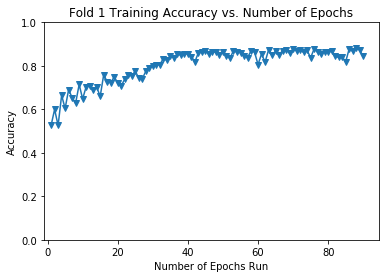

In [53]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_1f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 1 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

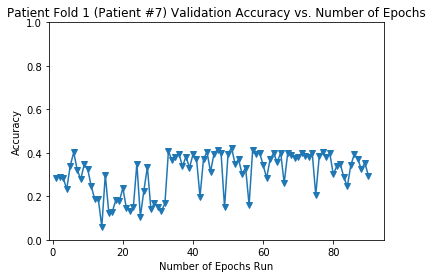

In [54]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_1f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 1 (Patient #7) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [55]:
# Second Patient (Patient #4)
graph_seed = 42
reset_graph(graph_seed)

In [56]:
# Second Validation Fold (Patient #4)
X_valid_fold = X_sorted[validation_2]
y_valid_fold = y_sorted[validation_2]

In [57]:
X_valid_fold.shape

(350, 380000)

In [58]:
y_valid_fold.shape

(350,)

In [59]:
# Validation Cube for patient fold 2 (Patient #4)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_2_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [60]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [61]:
# Second Training Fold (Patients 13,10,1,9,6,3,2,14,5,8,12,7)
X_train_fold = X_sorted[training_2]
y_train_fold = y_sorted[training_2]

In [62]:
X_train_fold.shape

(4025, 380000)

In [63]:
y_train_fold.shape

(4025,)

In [64]:
# Sets the Neural Network for the graph
height = 100
width = 100
channels = 38
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
# 4*4*pool6_fmaps is the size of the output of the last max poll layer
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 4 * 4])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [65]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [66]:
n_iterations_per_epoch

80

In [67]:
# Trains the CNN
acc_train_mat_2f = []
acc_valid_mat_2f = []

y_pred_valid_mat_2f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_2f.append(acc_train)
        acc_valid_mat_2f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_2f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_2f.append(y_pred_valid_2f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./SH_maxdata_baseneta_50tanh_2fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-04 20:03:34.131548 

Epoch 0
Last Batch accuracy:  46.00 %, Training accuracy:  57.52 %, Validation accuracy:  44.00 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  40  seconds.
Epoch 1
Last Batch accuracy:  50.00 %, Training accuracy:  54.76 %, Validation accuracy:  43.71 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  17  seconds.
Epoch 2
Last Batch accuracy:  60.00 %, Training accuracy:  61.49 %, Validation accuracy:  30.86 %
Time training up to Epoch  2 :  0  hours,  1  minutes, and  54  seconds.
Epoch 3
Last Batch accuracy:  20.00 %, Training accuracy:  53.14 %, Validation accuracy:  55.43 %
Time training up to Epoch  3 :  0  hours,  2  minutes, and  32  seconds.
Epoch 4
Last Batch accuracy:  46.00 %, Training accuracy:  52.72 %, Validation accuracy:  48.57 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  9  seconds.
Epoch 5
Last Batch accuracy:  58.00 %, Training accuracy:  60.25 %, Validation accuracy:  26.57 %
Time t

Last Batch accuracy:  90.00 %, Training accuracy:  81.89 %, Validation accuracy:  83.14 %
Time training up to Epoch  48 :  0  hours,  30  minutes, and  41  seconds.
Epoch 49
Last Batch accuracy:  90.00 %, Training accuracy:  83.50 %, Validation accuracy:  82.00 %
Time training up to Epoch  49 :  0  hours,  31  minutes, and  19  seconds.
Epoch 50
Last Batch accuracy:  78.00 %, Training accuracy:  77.39 %, Validation accuracy:  79.43 %
Time training up to Epoch  50 :  0  hours,  31  minutes, and  57  seconds.
Epoch 51
Last Batch accuracy:  90.00 %, Training accuracy:  82.26 %, Validation accuracy:  80.86 %
Time training up to Epoch  51 :  0  hours,  32  minutes, and  34  seconds.
Epoch 52
Last Batch accuracy:  84.00 %, Training accuracy:  83.01 %, Validation accuracy:  81.71 %
Time training up to Epoch  52 :  0  hours,  33  minutes, and  11  seconds.
Epoch 53
Last Batch accuracy:  78.00 %, Training accuracy:  82.39 %, Validation accuracy:  82.29 %
Time training up to Epoch  53 :  0  hour

In [68]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Second Patient Fold (Patient #4) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Second Patient Fold (Patient #4) of CV took 0  hours,  56  minutes, and  20  seconds to train.



In [69]:
valid_accuracy_2f = accuracy_score(y_valid_fold, y_pred_valid_2f)
valid_precision_2f = precision_score(y_valid_fold, y_pred_valid_2f)
valid_recall_2f = recall_score(y_valid_fold, y_pred_valid_2f)
valid_f1_2f = f1_score(y_valid_fold, y_pred_valid_2f)

print("Segment Validation Statistics, Second Patient Fold:\nAccuracy:\t\t",valid_accuracy_2f,
      "\nPrecision:\t\t",valid_precision_2f)
print("Recall:\t\t\t",valid_recall_2f,"\nF1 Score:\t\t",valid_f1_2f)

Segment Validation Statistics, Second Patient Fold:
Accuracy:		 0.84 
Precision:		 1.0
Recall:			 0.6266666666666667 
F1 Score:		 0.7704918032786886


In [70]:
valid_label = np.unique(y_valid_fold)
validation_cm_2f = confusion_matrix(y_valid_fold, y_pred_valid_2f, labels=valid_label) 

print("Second Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_2f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Second Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                200                  0
true:Nonleasional              56                 94


In [71]:
y_valid_cube_pred_2fold = group_hypercube(y_pred_valid_2f, cube_threshold, 
                                          validation_2_key, seg_length, seg_width)

In [72]:
valid_accuracy_cube_2f = accuracy_score(y_valid_cube, y_valid_cube_pred_2fold)
valid_precision_cube_2f = precision_score(y_valid_cube, y_valid_cube_pred_2fold)
valid_recall_cube_2f = recall_score(y_valid_cube, y_valid_cube_pred_2fold)
valid_f1_cube_2f = f1_score(y_valid_cube, y_valid_cube_pred_2fold)

print("Validation Model Hypercube Statistics, Second Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_2f,
      "\nHypercube Precision:\t\t",valid_precision_cube_2f)
print("Hypercube Recall: \t\t",valid_recall_cube_2f,"\nHypercube F1 Score:\t\t",valid_f1_cube_2f)

Validation Model Hypercube Statistics, Second Patient Fold:
Hypercube Accuracy:		 0.8571428571428571 
Hypercube Precision:		 1.0
Hypercube Recall: 		 0.6666666666666666 
Hypercube F1 Score:		 0.8


In [73]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_2f = confusion_matrix(y_valid_cube, y_valid_cube_pred_2fold, labels=valid_cube_label) 

print("Second Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_2f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Second Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  8                  0
true:Nonleasional               2                  4


In [74]:
avg_v_acc_2f, avg_v_prec_2f, avg_v_re_2f, avg_v_f1_2f, avg_v_cm_2f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_2f, y_valid_fold)

In [75]:
print("Average (20 Epochs) Segment Validation Statistics, Second Patient Fold:\nAccuracy:\t\t",avg_v_acc_2f,
      "\nPrecision:\t\t",avg_v_prec_2f)
print("Recall:\t\t\t",avg_v_re_2f,"\nF1 Score:\t\t",avg_v_f1_2f)

Average (20 Epochs) Segment Validation Statistics, Second Patient Fold:
Accuracy:		 0.8147142857142857 
Precision:		 0.9565534555766091
Recall:			 0.596 
F1 Score:		 0.7335714590283269


In [76]:
avgvalid_cm_2f =  avg_v_cm_2f.groupby(avg_v_cm_2f.index)

avgvalid_cm_2f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,195.75,4.25
true:Nonleasional,60.60,89.40


In [77]:
avg_vc_acc_2f, avg_vc_prec_2f, avg_vc_re_2f, avg_vc_f1_2f, avg_vc_cm_2f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_2f, 
                                                                                             cube_threshold, 
                                                                                             validation_2_key, 
                                                                                             seg_length, seg_width)
print("Average (20 Epochs) Hypercube Validation Statistics, Second Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_2f,
      "\nHypercube Precision:\t\t",avg_vc_prec_2f)
print("Hypercube Recall:\t\t",avg_vc_re_2f,"\nHypercube F1 Score:\t\t",avg_vc_f1_2f)


Average (20 Epochs) Hypercube Validation Statistics, Second Patient Fold:
Hypercube Accuracy:		 0.8357142857142857 
Hypercube Precision:		 0.99
Hypercube Recall:		 0.6249999999999999 
Hypercube F1 Score:		 0.763030303030303


In [78]:
avgvalid_cm_cube_2f =  avg_vc_cm_2f.groupby(avg_vc_cm_2f.index)

avgvalid_cm_cube_2f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,7.95,0.05
true:Nonleasional,2.25,3.75


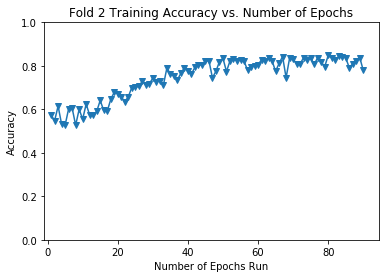

In [79]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_2f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 2 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

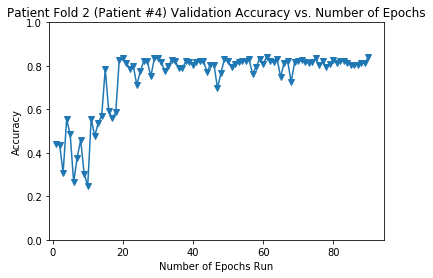

In [80]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_2f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 2 (Patient #4) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [81]:
# Third Patient (Patient #12)
graph_seed = 42
reset_graph(graph_seed)

In [82]:
# Third Validation Fold (Patient #12)
X_valid_fold = X_sorted[validation_3]
y_valid_fold = y_sorted[validation_3]

In [83]:
X_valid_fold.shape

(475, 380000)

In [84]:
y_valid_fold.shape

(475,)

In [85]:
# Validation Cube for patient fold 3 (Patient #12)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_3_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [86]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [87]:
# Third Training Fold (Patients 13,10,1,9,6,3,2,14,5,8,4,7)
X_train_fold = X_sorted[training_3]
y_train_fold = y_sorted[training_3]

In [88]:
X_train_fold.shape

(3900, 380000)

In [89]:
y_train_fold.shape

(3900,)

In [90]:
# Sets the Neural Network for the graph
height = 100
width = 100
channels = 38
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
# 4*4*pool6_fmaps is the size of the output of the last max poll layer
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 4 * 4])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [91]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [92]:
n_iterations_per_epoch

78

In [93]:
# Trains the CNN
acc_train_mat_3f = []
acc_valid_mat_3f = []

y_pred_valid_mat_3f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_3f.append(acc_train)
        acc_valid_mat_3f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_3f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_3f.append(y_pred_valid_3f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./SH_maxdata_baseneta_50tanh_3fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-04 21:00:31.102559 

Epoch 0
Last Batch accuracy:  56.00 %, Training accuracy:  59.10 %, Validation accuracy:  74.11 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  37  seconds.
Epoch 1
Last Batch accuracy:  50.00 %, Training accuracy:  50.23 %, Validation accuracy:  52.63 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  13  seconds.
Epoch 2
Last Batch accuracy:  68.00 %, Training accuracy:  61.92 %, Validation accuracy:  68.63 %
Time training up to Epoch  2 :  0  hours,  1  minutes, and  49  seconds.
Epoch 3
Last Batch accuracy:  40.00 %, Training accuracy:  49.79 %, Validation accuracy:  52.63 %
Time training up to Epoch  3 :  0  hours,  2  minutes, and  26  seconds.
Epoch 4
Last Batch accuracy:  56.00 %, Training accuracy:  51.28 %, Validation accuracy:  52.63 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  1  seconds.
Epoch 5
Last Batch accuracy:  60.00 %, Training accuracy:  50.03 %, Validation accuracy:  52.63 %
Time t

Last Batch accuracy:  66.00 %, Training accuracy:  80.62 %, Validation accuracy:  78.53 %
Time training up to Epoch  48 :  0  hours,  29  minutes, and  29  seconds.
Epoch 49
Last Batch accuracy:  90.00 %, Training accuracy:  80.56 %, Validation accuracy:  78.11 %
Time training up to Epoch  49 :  0  hours,  30  minutes, and  5  seconds.
Epoch 50
Last Batch accuracy:  68.00 %, Training accuracy:  72.74 %, Validation accuracy:  52.00 %
Time training up to Epoch  50 :  0  hours,  30  minutes, and  41  seconds.
Epoch 51
Last Batch accuracy:  72.00 %, Training accuracy:  78.21 %, Validation accuracy:  76.21 %
Time training up to Epoch  51 :  0  hours,  31  minutes, and  18  seconds.
Epoch 52
Last Batch accuracy:  84.00 %, Training accuracy:  82.38 %, Validation accuracy:  40.84 %
Time training up to Epoch  52 :  0  hours,  31  minutes, and  54  seconds.
Epoch 53
Last Batch accuracy:  74.00 %, Training accuracy:  81.56 %, Validation accuracy:  36.63 %
Time training up to Epoch  53 :  0  hours

In [94]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Third Patient Fold (Patient #12) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Third Patient Fold (Patient #12) of CV took 0  hours,  54  minutes, and  11  seconds to train.



In [95]:
valid_accuracy_3f = accuracy_score(y_valid_fold, y_pred_valid_3f)
valid_precision_3f = precision_score(y_valid_fold, y_pred_valid_3f)
valid_recall_3f = recall_score(y_valid_fold, y_pred_valid_3f)
valid_f1_3f = f1_score(y_valid_fold, y_pred_valid_3f)

print("Segment Validation Statistics, Third Patient Fold:\nAccuracy:\t\t",valid_accuracy_3f,
      "\nPrecision:\t\t",valid_precision_3f)
print("Recall:\t\t\t",valid_recall_3f,"\nF1 Score:\t\t",valid_f1_3f)

Segment Validation Statistics, Third Patient Fold:
Accuracy:		 0.6021052631578947 
Precision:		 0.5841121495327103
Recall:			 0.5555555555555556 
F1 Score:		 0.5694760820045559


In [96]:
valid_label = np.unique(y_valid_fold)
validation_cm_3f = confusion_matrix(y_valid_fold, y_pred_valid_3f, labels=valid_label) 

print("Third Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_3f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Third Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                161                 89
true:Nonleasional             100                125


In [97]:
y_valid_cube_pred_3fold = group_hypercube(y_pred_valid_3f, cube_threshold, 
                                          validation_3_key, seg_length, seg_width)

In [98]:
valid_accuracy_cube_3f = accuracy_score(y_valid_cube, y_valid_cube_pred_3fold)
valid_precision_cube_3f = precision_score(y_valid_cube, y_valid_cube_pred_3fold)
valid_recall_cube_3f = recall_score(y_valid_cube, y_valid_cube_pred_3fold)
valid_f1_cube_3f = f1_score(y_valid_cube, y_valid_cube_pred_3fold)

print("Validation Model Hypercube Statistics, Third Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_3f,
      "\nHypercube Precision:\t\t",valid_precision_cube_3f)
print("Hypercube Recall: \t\t",valid_recall_cube_3f,"\nHypercube F1 Score:\t\t",valid_f1_cube_3f)

Validation Model Hypercube Statistics, Third Patient Fold:
Hypercube Accuracy:		 0.631578947368421 
Hypercube Precision:		 0.625
Hypercube Recall: 		 0.5555555555555556 
Hypercube F1 Score:		 0.5882352941176471


In [99]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_3f = confusion_matrix(y_valid_cube, y_valid_cube_pred_3fold, labels=valid_cube_label) 

print("Third Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_3f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Third Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  7                  3
true:Nonleasional               4                  5


In [100]:
avg_v_acc_3f, avg_v_prec_3f, avg_v_re_3f, avg_v_f1_3f, avg_v_cm_3f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_3f, y_valid_fold)

In [101]:
print("Average (20 Epochs) Segment Validation Statistics, Third Patient Fold:\nAccuracy:\t\t",avg_v_acc_3f,
      "\nPrecision:\t\t",avg_v_prec_3f)
print("Recall:\t\t\t",avg_v_re_3f,"\nF1 Score:\t\t",avg_v_f1_3f)

Average (20 Epochs) Segment Validation Statistics, Third Patient Fold:
Accuracy:		 0.5584210526315788 
Precision:		 0.5741094208266336
Recall:			 0.555111111111111 
F1 Score:		 0.5515128738617749


In [102]:
avgvalid_cm_3f =  avg_v_cm_3f.groupby(avg_v_cm_3f.index)

avgvalid_cm_3f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,140.35,109.65
true:Nonleasional,100.10,124.90


In [103]:
avg_vc_acc_3f, avg_vc_prec_3f, avg_vc_re_3f, avg_vc_f1_3f, avg_vc_cm_3f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_3f, 
                                                                                             cube_threshold, 
                                                                                             validation_3_key, 
                                                                                             seg_length, seg_width)
print("Average (20 Epochs) Hypercube Validation Statistics, Third Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_3f,
      "\nHypercube Precision:\t\t",avg_vc_prec_3f)
print("Hypercube Recall:\t\t",avg_vc_re_3f,"\nHypercube F1 Score:\t\t",avg_vc_f1_3f)


Average (20 Epochs) Hypercube Validation Statistics, Third Patient Fold:
Hypercube Accuracy:		 0.568421052631579 
Hypercube Precision:		 0.5872141747141747
Hypercube Recall:		 0.5555555555555556 
Hypercube F1 Score:		 0.5588246025821743


In [104]:
avgvalid_cm_cube_3f =  avg_vc_cm_3f.groupby(avg_vc_cm_3f.index)

avgvalid_cm_cube_3f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,5.8,4.2
true:Nonleasional,4.0,5.0


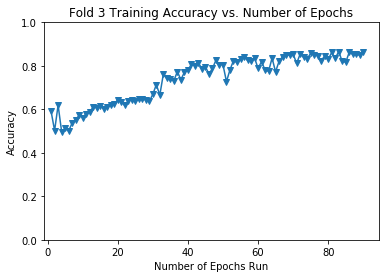

In [105]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_3f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 3 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

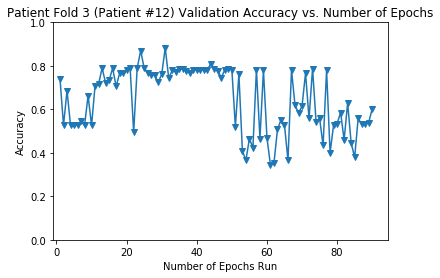

In [106]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_3f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 3 (Patient #12) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [107]:
# Fourth Patient (Patient #8)
graph_seed = 42
reset_graph(graph_seed)

In [108]:
# Fourth Validation Fold (Patient #8)
X_valid_fold = X_sorted[validation_4]
y_valid_fold = y_sorted[validation_4]

In [109]:
X_valid_fold.shape

(375, 380000)

In [110]:
y_valid_fold.shape

(375,)

In [111]:
# Validation Cube for patient fold 4 (Patient #8)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_4_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [112]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [113]:
# Fourth Training Fold (Patients 13,10,1,9,6,3,2,14,5,12,4,7)
X_train_fold = X_sorted[training_4]
y_train_fold = y_sorted[training_4]

In [114]:
X_train_fold.shape

(4000, 380000)

In [115]:
y_train_fold.shape

(4000,)

In [116]:
# Sets the Neural Network for the graph
height = 100
width = 100
channels = 38
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
# 4*4*pool6_fmaps is the size of the output of the last max poll layer
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 4 * 4])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [117]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [118]:
n_iterations_per_epoch

80

In [119]:
# Trains the CNN
acc_train_mat_4f = []
acc_valid_mat_4f = []

y_pred_valid_mat_4f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_4f.append(acc_train)
        acc_valid_mat_4f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_4f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_4f.append(y_pred_valid_4f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./SH_maxdata_baseneta_50tanh_4fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-04 21:55:22.097797 

Epoch 0
Last Batch accuracy:  52.00 %, Training accuracy:  58.98 %, Validation accuracy:  0.00 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  38  seconds.
Epoch 1
Last Batch accuracy:  66.00 %, Training accuracy:  58.07 %, Validation accuracy:  59.20 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  16  seconds.
Epoch 2
Last Batch accuracy:  62.00 %, Training accuracy:  64.28 %, Validation accuracy:  34.67 %
Time training up to Epoch  2 :  0  hours,  1  minutes, and  53  seconds.
Epoch 3
Last Batch accuracy:  44.00 %, Training accuracy:  50.72 %, Validation accuracy:  60.00 %
Time training up to Epoch  3 :  0  hours,  2  minutes, and  30  seconds.
Epoch 4
Last Batch accuracy:  56.00 %, Training accuracy:  50.28 %, Validation accuracy:  60.00 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  7  seconds.
Epoch 5
Last Batch accuracy:  64.00 %, Training accuracy:  64.45 %, Validation accuracy:  50.67 %
Time tr

Last Batch accuracy:  82.00 %, Training accuracy:  77.33 %, Validation accuracy:  35.73 %
Time training up to Epoch  48 :  0  hours,  30  minutes, and  28  seconds.
Epoch 49
Last Batch accuracy:  74.00 %, Training accuracy:  78.97 %, Validation accuracy:  58.67 %
Time training up to Epoch  49 :  0  hours,  31  minutes, and  5  seconds.
Epoch 50
Last Batch accuracy:  70.00 %, Training accuracy:  78.40 %, Validation accuracy:  38.13 %
Time training up to Epoch  50 :  0  hours,  31  minutes, and  42  seconds.
Epoch 51
Last Batch accuracy:  84.00 %, Training accuracy:  80.80 %, Validation accuracy:  58.93 %
Time training up to Epoch  51 :  0  hours,  32  minutes, and  20  seconds.
Epoch 52
Last Batch accuracy:  92.00 %, Training accuracy:  78.97 %, Validation accuracy:  32.53 %
Time training up to Epoch  52 :  0  hours,  32  minutes, and  57  seconds.
Epoch 53
Last Batch accuracy:  80.00 %, Training accuracy:  79.88 %, Validation accuracy:  42.13 %
Time training up to Epoch  53 :  0  hours

In [120]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Fourth Patient Fold (Patient #8) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Fourth Patient Fold (Patient #8) of CV took 0  hours,  55  minutes, and  58  seconds to train.



In [121]:
valid_accuracy_4f = accuracy_score(y_valid_fold, y_pred_valid_4f)
valid_precision_4f = precision_score(y_valid_fold, y_pred_valid_4f)
valid_recall_4f = recall_score(y_valid_fold, y_pred_valid_4f)
valid_f1_4f = f1_score(y_valid_fold, y_pred_valid_4f)

print("Segment Validation Statistics, Fourth Patient Fold:\nAccuracy:\t\t",valid_accuracy_4f,
      "\nPrecision:\t\t",valid_precision_4f)
print("Recall:\t\t\t",valid_recall_4f,"\nF1 Score:\t\t",valid_f1_4f)

Segment Validation Statistics, Fourth Patient Fold:
Accuracy:		 0.592 
Precision:		 0.0
Recall:			 0.0 
F1 Score:		 0.0


In [122]:
valid_label = np.unique(y_valid_fold)
validation_cm_4f = confusion_matrix(y_valid_fold, y_pred_valid_4f, labels=valid_label) 

print("Fourth Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_4f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Fourth Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                222                  3
true:Nonleasional             150                  0


In [123]:
y_valid_cube_pred_4fold = group_hypercube(y_pred_valid_4f, cube_threshold, 
                                          validation_4_key, seg_length, seg_width)

In [124]:
valid_accuracy_cube_4f = accuracy_score(y_valid_cube, y_valid_cube_pred_4fold)
valid_precision_cube_4f = precision_score(y_valid_cube, y_valid_cube_pred_4fold)
valid_recall_cube_4f = recall_score(y_valid_cube, y_valid_cube_pred_4fold)
valid_f1_cube_4f = f1_score(y_valid_cube, y_valid_cube_pred_4fold)

print("Validation Model Hypercube Statistics, Fourth Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_4f,
      "\nHypercube Precision:\t\t",valid_precision_cube_4f)
print("Hypercube Recall: \t\t",valid_recall_cube_4f,"\nHypercube F1 Score:\t\t",valid_f1_cube_4f)

Validation Model Hypercube Statistics, Fourth Patient Fold:
Hypercube Accuracy:		 0.6 
Hypercube Precision:		 0.0
Hypercube Recall: 		 0.0 
Hypercube F1 Score:		 0.0


C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [125]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_4f = confusion_matrix(y_valid_cube, y_valid_cube_pred_4fold, labels=valid_cube_label) 

print("Fourth Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_4f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Fourth Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  9                  0
true:Nonleasional               6                  0


In [126]:
avg_v_acc_4f, avg_v_prec_4f, avg_v_re_4f, avg_v_f1_4f, avg_v_cm_4f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_4f, y_valid_fold)

C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [127]:
print("Average (20 Epochs) Segment Validation Statistics, Fourth Patient Fold:\nAccuracy:\t\t",avg_v_acc_4f,
      "\nPrecision:\t\t",avg_v_prec_4f)
print("Recall:\t\t\t",avg_v_re_4f,"\nF1 Score:\t\t",avg_v_f1_4f)

Average (20 Epochs) Segment Validation Statistics, Fourth Patient Fold:
Accuracy:		 0.5470666666666668 
Precision:		 0.0
Recall:			 0.0 
F1 Score:		 0.0


In [128]:
avgvalid_cm_4f =  avg_v_cm_4f.groupby(avg_v_cm_4f.index)

avgvalid_cm_4f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,205.15,19.85
true:Nonleasional,150.00,0.00


In [129]:
avg_vc_acc_4f, avg_vc_prec_4f, avg_vc_re_4f, avg_vc_f1_4f, avg_vc_cm_4f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_4f, 
                                                                                             cube_threshold, 
                                                                                             validation_4_key, 
                                                                                             seg_length, seg_width)
print("Average (20 Epochs) Hypercube Validation Statistics, Fourth Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_4f,
      "\nHypercube Precision:\t\t",avg_vc_prec_4f)
print("Hypercube Recall:\t\t",avg_vc_re_4f,"\nHypercube F1 Score:\t\t",avg_vc_f1_4f)


Average (20 Epochs) Hypercube Validation Statistics, Fourth Patient Fold:
Hypercube Accuracy:		 0.5599999999999999 
Hypercube Precision:		 0.0
Hypercube Recall:		 0.0 
Hypercube F1 Score:		 0.0


C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [130]:
avgvalid_cm_cube_4f =  avg_vc_cm_4f.groupby(avg_vc_cm_4f.index)

avgvalid_cm_cube_4f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,8.4,0.6
true:Nonleasional,6.0,0.0


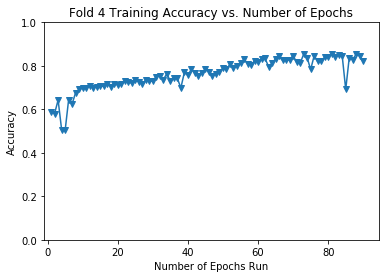

In [131]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_4f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 4 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

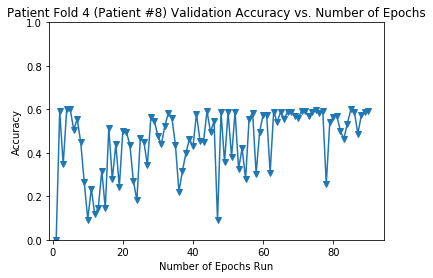

In [132]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_4f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 4 (Patient #8) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [133]:
# Fifth Patient (Patient #5)
graph_seed = 42
reset_graph(graph_seed)

In [134]:
# Fifth Validation Fold (Patient #5)
X_valid_fold = X_sorted[validation_5]
y_valid_fold = y_sorted[validation_5]

In [135]:
X_valid_fold.shape

(450, 380000)

In [136]:
y_valid_fold.shape

(450,)

In [137]:
# Validation Cube for patient fold 5 (Patient #5)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_5_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [138]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [139]:
# Fifth Training Fold (Patients 13,10,1,9,6,3,2,14,8,12,4,7)
X_train_fold = X_sorted[training_5]
y_train_fold = y_sorted[training_5]

In [140]:
X_train_fold.shape

(3925, 380000)

In [141]:
y_train_fold.shape

(3925,)

In [142]:
# Sets the Neural Network for the graph
height = 100
width = 100
channels = 38
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
# 4*4*pool6_fmaps is the size of the output of the last max poll layer
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 4 * 4])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [143]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [144]:
n_iterations_per_epoch

78

In [145]:
# Trains the CNN
acc_train_mat_5f = []
acc_valid_mat_5f = []

y_pred_valid_mat_5f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_5f.append(acc_train)
        acc_valid_mat_5f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_5f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_5f.append(y_pred_valid_5f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./SH_maxdata_baseneta_50tanh_5fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-04 22:52:10.950000 

Epoch 0
Last Batch accuracy:  60.00 %, Training accuracy:  59.06 %, Validation accuracy:  81.33 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  37  seconds.
Epoch 1
Last Batch accuracy:  34.00 %, Training accuracy:  50.73 %, Validation accuracy:  50.00 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  14  seconds.
Epoch 2
Last Batch accuracy:  66.00 %, Training accuracy:  61.04 %, Validation accuracy:  74.89 %
Time training up to Epoch  2 :  0  hours,  1  minutes, and  51  seconds.
Epoch 3
Last Batch accuracy:  40.00 %, Training accuracy:  51.18 %, Validation accuracy:  50.00 %
Time training up to Epoch  3 :  0  hours,  2  minutes, and  27  seconds.
Epoch 4
Last Batch accuracy:  40.00 %, Training accuracy:  53.61 %, Validation accuracy:  50.00 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  4  seconds.
Epoch 5
Last Batch accuracy:  66.00 %, Training accuracy:  63.36 %, Validation accuracy:  24.00 %
Time t

Last Batch accuracy:  62.00 %, Training accuracy:  76.43 %, Validation accuracy:  41.11 %
Time training up to Epoch  48 :  0  hours,  29  minutes, and  45  seconds.
Epoch 49
Last Batch accuracy:  70.00 %, Training accuracy:  68.97 %, Validation accuracy:  52.22 %
Time training up to Epoch  49 :  0  hours,  30  minutes, and  21  seconds.
Epoch 50
Last Batch accuracy:  76.00 %, Training accuracy:  78.22 %, Validation accuracy:  45.78 %
Time training up to Epoch  50 :  0  hours,  30  minutes, and  57  seconds.
Epoch 51
Last Batch accuracy:  84.00 %, Training accuracy:  77.40 %, Validation accuracy:  42.89 %
Time training up to Epoch  51 :  0  hours,  31  minutes, and  34  seconds.
Epoch 52
Last Batch accuracy:  84.00 %, Training accuracy:  76.64 %, Validation accuracy:  54.22 %
Time training up to Epoch  52 :  0  hours,  32  minutes, and  11  seconds.
Epoch 53
Last Batch accuracy:  80.00 %, Training accuracy:  77.86 %, Validation accuracy:  50.44 %
Time training up to Epoch  53 :  0  hour

In [146]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Fifth Patient Fold (Patient #5) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Fifth Patient Fold (Patient #5) of CV took 0  hours,  54  minutes, and  42  seconds to train.



In [147]:
valid_accuracy_5f = accuracy_score(y_valid_fold, y_pred_valid_5f)
valid_precision_5f = precision_score(y_valid_fold, y_pred_valid_5f)
valid_recall_5f = recall_score(y_valid_fold, y_pred_valid_5f)
valid_f1_5f = f1_score(y_valid_fold, y_pred_valid_5f)

print("Segment Validation Statistics, Fifth Patient Fold:\nAccuracy:\t\t",valid_accuracy_5f,
      "\nPrecision:\t\t",valid_precision_5f)
print("Recall:\t\t\t",valid_recall_5f,"\nF1 Score:\t\t",valid_f1_5f)

Segment Validation Statistics, Fifth Patient Fold:
Accuracy:		 0.5377777777777778 
Precision:		 0.6231884057971014
Recall:			 0.19111111111111112 
F1 Score:		 0.2925170068027211


In [148]:
valid_label = np.unique(y_valid_fold)
validation_cm_5f = confusion_matrix(y_valid_fold, y_pred_valid_5f, labels=valid_label) 

print("Fifth Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_5f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Fifth Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                199                 26
true:Nonleasional             182                 43


In [149]:
y_valid_cube_pred_5fold = group_hypercube(y_pred_valid_5f, cube_threshold, 
                                          validation_5_key, seg_length, seg_width)

In [150]:
valid_accuracy_cube_5f = accuracy_score(y_valid_cube, y_valid_cube_pred_5fold)
valid_precision_cube_5f = precision_score(y_valid_cube, y_valid_cube_pred_5fold)
valid_recall_cube_5f = recall_score(y_valid_cube, y_valid_cube_pred_5fold)
valid_f1_cube_5f = f1_score(y_valid_cube, y_valid_cube_pred_5fold)

print("Validation Model Hypercube Statistics, Fifth Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_5f,
      "\nHypercube Precision:\t\t",valid_precision_cube_5f)
print("Hypercube Recall: \t\t",valid_recall_cube_5f,"\nHypercube F1 Score:\t\t",valid_f1_cube_5f)

Validation Model Hypercube Statistics, Fifth Patient Fold:
Hypercube Accuracy:		 0.5555555555555556 
Hypercube Precision:		 0.6666666666666666
Hypercube Recall: 		 0.2222222222222222 
Hypercube F1 Score:		 0.3333333333333333


In [151]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_5f = confusion_matrix(y_valid_cube, y_valid_cube_pred_5fold, labels=valid_cube_label) 

print("Fifth Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_5f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Fifth Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  8                  1
true:Nonleasional               7                  2


In [152]:
avg_v_acc_5f, avg_v_prec_5f, avg_v_re_5f, avg_v_f1_5f, avg_v_cm_5f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_5f, y_valid_fold)

In [153]:
print("Average (20 Epochs) Segment Validation Statistics, Fifth Patient Fold:\nAccuracy:\t\t",avg_v_acc_5f,
      "\nPrecision:\t\t",avg_v_prec_5f)
print("Recall:\t\t\t",avg_v_re_5f,"\nF1 Score:\t\t",avg_v_f1_5f)

Average (20 Epochs) Segment Validation Statistics, Fifth Patient Fold:
Accuracy:		 0.5521111111111111 
Precision:		 0.5783534335073559
Recall:			 0.30711111111111106 
F1 Score:		 0.3836828513935565


In [154]:
avgvalid_cm_5f =  avg_v_cm_5f.groupby(avg_v_cm_5f.index)

avgvalid_cm_5f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,179.35,45.65
true:Nonleasional,155.90,69.10


In [155]:
avg_vc_acc_5f, avg_vc_prec_5f, avg_vc_re_5f, avg_vc_f1_5f, avg_vc_cm_5f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_5f, 
                                                                                             cube_threshold, 
                                                                                             validation_5_key, 
                                                                                             seg_length, seg_width)
print("Average (20 Epochs) Hypercube Validation Statistics, Fifth Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_5f,
      "\nHypercube Precision:\t\t",avg_vc_prec_5f)
print("Hypercube Recall:\t\t",avg_vc_re_5f,"\nHypercube F1 Score:\t\t",avg_vc_f1_5f)


Average (20 Epochs) Hypercube Validation Statistics, Fifth Patient Fold:
Hypercube Accuracy:		 0.5388888888888889 
Hypercube Precision:		 0.4898214285714285
Hypercube Recall:		 0.3055555555555555 
Hypercube F1 Score:		 0.3632279485220662


C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [156]:
avgvalid_cm_cube_5f =  avg_vc_cm_5f.groupby(avg_vc_cm_5f.index)

avgvalid_cm_cube_5f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,6.95,2.05
true:Nonleasional,6.25,2.75


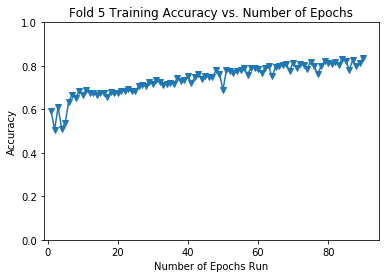

In [157]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_5f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 5 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

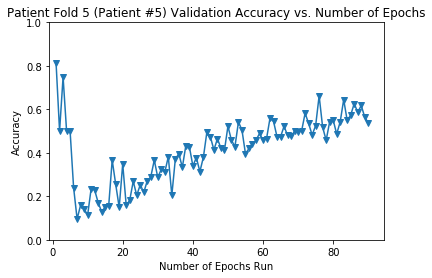

In [158]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_5f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 5 (Patient #5) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [159]:
# Sixth Patient (Patient #14)
graph_seed = 42
reset_graph(graph_seed)

In [160]:
# Sixth Validation Fold (Patient #14)
X_valid_fold = X_sorted[validation_6]
y_valid_fold = y_sorted[validation_6]

In [161]:
X_valid_fold.shape

(250, 380000)

In [162]:
y_valid_fold.shape

(250,)

In [163]:
# Validation Cube for fold 6 (Patient #14)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_6_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [164]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [165]:
# Second Training Fold (Patients 13,10,1,9,6,3,2,5,8,12,4,7)
X_train_fold = X_sorted[training_6]
y_train_fold = y_sorted[training_6]

In [166]:
X_train_fold.shape

(4125, 380000)

In [167]:
y_train_fold.shape

(4125,)

In [168]:
# Sets the Neural Network for the graph
height = 100
width = 100
channels = 38
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
# 4*4*pool6_fmaps is the size of the output of the last max poll layer
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 4 * 4])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [169]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [170]:
n_iterations_per_epoch

82

In [171]:
# Trains the CNN
acc_train_mat_6f = []
acc_valid_mat_6f = []

y_pred_valid_mat_6f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_6f.append(acc_train)
        acc_valid_mat_6f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_6f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_6f.append(y_pred_valid_6f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./SH_maxdata_baseneta_50tanh_6fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-04 23:47:41.608432 

Epoch 0
Last Batch accuracy:  66.00 %, Training accuracy:  53.26 %, Validation accuracy:  20.00 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  40  seconds.
Epoch 1
Last Batch accuracy:  42.00 %, Training accuracy:  52.73 %, Validation accuracy:  20.00 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  21  seconds.
Epoch 2
Last Batch accuracy:  42.00 %, Training accuracy:  51.81 %, Validation accuracy:  20.00 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  1  seconds.
Epoch 3
Last Batch accuracy:  60.00 %, Training accuracy:  53.33 %, Validation accuracy:  36.40 %
Time training up to Epoch  3 :  0  hours,  2  minutes, and  42  seconds.
Epoch 4
Last Batch accuracy:  48.00 %, Training accuracy:  52.61 %, Validation accuracy:  25.20 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  23  seconds.
Epoch 5
Last Batch accuracy:  60.00 %, Training accuracy:  52.99 %, Validation accuracy:  36.40 %
Time t

Last Batch accuracy:  82.00 %, Training accuracy:  77.60 %, Validation accuracy:  89.20 %
Time training up to Epoch  48 :  0  hours,  31  minutes, and  44  seconds.
Epoch 49
Last Batch accuracy:  74.00 %, Training accuracy:  77.14 %, Validation accuracy:  85.20 %
Time training up to Epoch  49 :  0  hours,  32  minutes, and  23  seconds.
Epoch 50
Last Batch accuracy:  64.00 %, Training accuracy:  78.86 %, Validation accuracy:  94.00 %
Time training up to Epoch  50 :  0  hours,  33  minutes, and  1  seconds.
Epoch 51
Last Batch accuracy:  88.00 %, Training accuracy:  81.58 %, Validation accuracy:  86.80 %
Time training up to Epoch  51 :  0  hours,  33  minutes, and  40  seconds.
Epoch 52
Last Batch accuracy:  80.00 %, Training accuracy:  82.98 %, Validation accuracy:  91.20 %
Time training up to Epoch  52 :  0  hours,  34  minutes, and  18  seconds.
Epoch 53
Last Batch accuracy:  86.00 %, Training accuracy:  81.07 %, Validation accuracy:  86.00 %
Time training up to Epoch  53 :  0  hours

In [172]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Sixth Patient Fold (Patient #14) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Sixth Patient Fold (Patient #14) of CV took 0  hours,  58  minutes, and  2  seconds to train.



In [173]:
valid_accuracy_6f = accuracy_score(y_valid_fold, y_pred_valid_6f)
valid_precision_6f = precision_score(y_valid_fold, y_pred_valid_6f)
valid_recall_6f = recall_score(y_valid_fold, y_pred_valid_6f)
valid_f1_6f = f1_score(y_valid_fold, y_pred_valid_6f)

print("Segment Validation Statistics, Sixth Patient Fold:\nAccuracy:\t\t",valid_accuracy_6f,
      "\nPrecision:\t\t",valid_precision_6f)
print("Recall:\t\t\t",valid_recall_6f,"\nF1 Score:\t\t",valid_f1_6f)

Segment Validation Statistics, Sixth Patient Fold:
Accuracy:		 0.916 
Precision:		 1.0
Recall:			 0.895 
F1 Score:		 0.9445910290237467


In [174]:
valid_label = np.unique(y_valid_fold)
validation_cm_6f = confusion_matrix(y_valid_fold, y_pred_valid_6f, labels=valid_label) 

print("Sixth Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_6f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Sixth Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                 50                  0
true:Nonleasional              21                179


In [175]:
y_valid_cube_pred_6fold = group_hypercube(y_pred_valid_6f, cube_threshold, 
                                          validation_6_key, seg_length, seg_width)

In [176]:
valid_accuracy_cube_6f = accuracy_score(y_valid_cube, y_valid_cube_pred_6fold)
valid_precision_cube_6f = precision_score(y_valid_cube, y_valid_cube_pred_6fold)
valid_recall_cube_6f = recall_score(y_valid_cube, y_valid_cube_pred_6fold)
valid_f1_cube_6f = f1_score(y_valid_cube, y_valid_cube_pred_6fold)

print("Validation Model Hypercube Statistics, Sixth Patient Fold (Patient #14):\nHypercube Accuracy:\t\t",valid_accuracy_cube_6f,
      "\nHypercube Precision:\t\t",valid_precision_cube_6f)
print("Hypercube Recall: \t\t",valid_recall_cube_6f,"\nHypercube F1 Score:\t\t",valid_f1_cube_6f)

Validation Model Hypercube Statistics, Sixth Patient Fold (Patient #14):
Hypercube Accuracy:		 0.9 
Hypercube Precision:		 1.0
Hypercube Recall: 		 0.875 
Hypercube F1 Score:		 0.9333333333333333


In [177]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_6f = confusion_matrix(y_valid_cube, y_valid_cube_pred_6fold, labels=valid_cube_label) 

print("Sixth Patient Fold (Patient #14) Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_6f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Sixth Patient Fold (Patient #14) Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  2                  0
true:Nonleasional               1                  7


In [178]:
avg_v_acc_6f, avg_v_prec_6f, avg_v_re_6f, avg_v_f1_6f, avg_v_cm_6f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_6f, y_valid_fold)

In [179]:
print("Average (20 Epochs) Segment Validation Statistics, Sixth Patient Fold:\nAccuracy:\t\t",avg_v_acc_6f,
      "\nPrecision:\t\t",avg_v_prec_6f)
print("Recall:\t\t\t",avg_v_re_6f,"\nF1 Score:\t\t",avg_v_f1_6f)

Average (20 Epochs) Segment Validation Statistics, Sixth Patient Fold:
Accuracy:		 0.8704000000000001 
Precision:		 0.9901307649603475
Recall:			 0.8474999999999999 
F1 Score:		 0.9104723915798765


In [180]:
avgvalid_cm_6f =  avg_v_cm_6f.groupby(avg_v_cm_6f.index)

avgvalid_cm_6f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,48.1,1.9
true:Nonleasional,30.5,169.5


In [181]:
avg_vc_acc_6f, avg_vc_prec_6f, avg_vc_re_6f, avg_vc_f1_6f, avg_vc_cm_6f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_6f, 
                                                                                             cube_threshold, 
                                                                                             validation_6_key, 
                                                                                             seg_length, seg_width)
print("Average (20 Epochs) Hypercube Validation Statistics, Sixth Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_6f,
      "\nHypercube Precision:\t\t",avg_vc_prec_6f)
print("Hypercube Recall:\t\t",avg_vc_re_6f,"\nHypercube F1 Score:\t\t",avg_vc_f1_6f)


Average (20 Epochs) Hypercube Validation Statistics, Sixth Patient Fold:
Hypercube Accuracy:		 0.885 
Hypercube Precision:		 1.0
Hypercube Recall:		 0.85625 
Hypercube F1 Score:		 0.9204761904761904


In [182]:
avgvalid_cm_cube_6f =  avg_vc_cm_6f.groupby(avg_vc_cm_6f.index)

avgvalid_cm_cube_6f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,2.00,0.00
true:Nonleasional,1.15,6.85


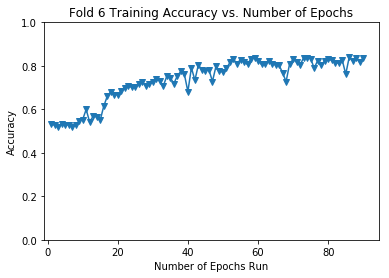

In [183]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_6f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 6 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

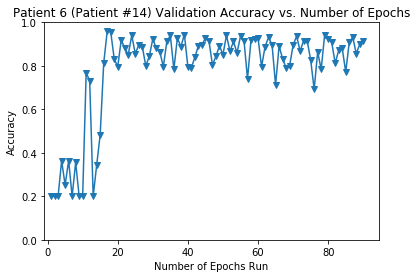

In [184]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_6f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient 6 (Patient #14) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [185]:
# Seventh Patient (Patient 2)
graph_seed = 42
reset_graph(graph_seed)

In [186]:
# Seventh Validation Fold (Patient 2)
X_valid_fold = X_sorted[validation_7]
y_valid_fold = y_sorted[validation_7]

In [187]:
X_valid_fold.shape

(225, 380000)

In [188]:
y_valid_fold.shape

(225,)

In [189]:
# Validation Cube for patient fold 7 (Patient #2)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_7_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [190]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [191]:
# Third Training Fold (Patients 13,10,1,9,6,3,14,5,8,12,4,7)
X_train_fold = X_sorted[training_7]
y_train_fold = y_sorted[training_7]

In [192]:
X_train_fold.shape

(4150, 380000)

In [193]:
y_train_fold.shape

(4150,)

In [194]:
# Sets the Neural Network for the graph
height = 100
width = 100
channels = 38
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
# 4*4*pool6_fmaps is the size of the output of the last max poll layer
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 4 * 4])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [195]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [196]:
n_iterations_per_epoch

83

In [197]:
# Trains the CNN
acc_train_mat_7f = []
acc_valid_mat_7f = []

y_pred_valid_mat_7f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_7f.append(acc_train)
        acc_valid_mat_7f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_7f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_7f.append(y_pred_valid_7f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./SH_maxdata_baseneta_50tanh_7fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-05 00:46:49.073703 

Epoch 0
Last Batch accuracy:  54.00 %, Training accuracy:  60.22 %, Validation accuracy:  44.44 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  39  seconds.
Epoch 1
Last Batch accuracy:  54.00 %, Training accuracy:  59.93 %, Validation accuracy:  44.44 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  20  seconds.
Epoch 2
Last Batch accuracy:  66.00 %, Training accuracy:  61.98 %, Validation accuracy:  44.44 %
Time training up to Epoch  2 :  0  hours,  1  minutes, and  59  seconds.
Epoch 3
Last Batch accuracy:  66.00 %, Training accuracy:  61.90 %, Validation accuracy:  44.44 %
Time training up to Epoch  3 :  0  hours,  2  minutes, and  37  seconds.
Epoch 4
Last Batch accuracy:  60.00 %, Training accuracy:  63.13 %, Validation accuracy:  44.44 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  16  seconds.
Epoch 5
Last Batch accuracy:  58.00 %, Training accuracy:  63.42 %, Validation accuracy:  44.44 %
Time 

Last Batch accuracy:  88.00 %, Training accuracy:  82.48 %, Validation accuracy:  66.22 %
Time training up to Epoch  48 :  0  hours,  32  minutes, and  16  seconds.
Epoch 49
Last Batch accuracy:  64.00 %, Training accuracy:  73.18 %, Validation accuracy:  86.22 %
Time training up to Epoch  49 :  0  hours,  32  minutes, and  55  seconds.
Epoch 50
Last Batch accuracy:  74.00 %, Training accuracy:  82.53 %, Validation accuracy:  52.44 %
Time training up to Epoch  50 :  0  hours,  33  minutes, and  34  seconds.
Epoch 51
Last Batch accuracy:  84.00 %, Training accuracy:  83.01 %, Validation accuracy:  61.78 %
Time training up to Epoch  51 :  0  hours,  34  minutes, and  13  seconds.
Epoch 52
Last Batch accuracy:  80.00 %, Training accuracy:  82.12 %, Validation accuracy:  52.00 %
Time training up to Epoch  52 :  0  hours,  34  minutes, and  52  seconds.
Epoch 53
Last Batch accuracy:  84.00 %, Training accuracy:  77.78 %, Validation accuracy:  79.56 %
Time training up to Epoch  53 :  0  hour

In [198]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Seventh Patient Fold (Patient #2) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Seventh Patient Fold (Patient #2) of CV took 0  hours,  59  minutes, and  8  seconds to train.



In [199]:
valid_accuracy_7f = accuracy_score(y_valid_fold, y_pred_valid_7f)
valid_precision_7f = precision_score(y_valid_fold, y_pred_valid_7f)
valid_recall_7f = recall_score(y_valid_fold, y_pred_valid_7f)
valid_f1_7f = f1_score(y_valid_fold, y_pred_valid_7f)

print("Segment Validation Statistics, Seventh Patient Fold:\nAccuracy:\t\t",valid_accuracy_7f,
      "\nPrecision:\t\t",valid_precision_7f)
print("Recall:\t\t\t",valid_recall_7f,"\nF1 Score:\t\t",valid_f1_7f)

Segment Validation Statistics, Seventh Patient Fold:
Accuracy:		 0.5422222222222223 
Precision:		 0.49222797927461137
Recall:			 0.95 
F1 Score:		 0.6484641638225256


In [200]:
valid_label = np.unique(y_valid_fold)
validation_cm_7f = confusion_matrix(y_valid_fold, y_pred_valid_7f, labels=valid_label) 

print("Seventh Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_7f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Seventh Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                 27                 98
true:Nonleasional               5                 95


In [201]:
y_valid_cube_pred_7fold = group_hypercube(y_pred_valid_7f, cube_threshold, 
                                          validation_7_key, seg_length, seg_width)

In [202]:
valid_accuracy_cube_7f = accuracy_score(y_valid_cube, y_valid_cube_pred_7fold)
valid_precision_cube_7f = precision_score(y_valid_cube, y_valid_cube_pred_7fold)
valid_recall_cube_7f = recall_score(y_valid_cube, y_valid_cube_pred_7fold)
valid_f1_cube_7f = f1_score(y_valid_cube, y_valid_cube_pred_7fold)

print("Validation Model Hypercube Statistics, Seventh Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_7f,
      "\nHypercube Precision:\t\t",valid_precision_cube_7f)
print("Hypercube Recall: \t\t",valid_recall_cube_7f,"\nHypercube F1 Score:\t\t",valid_f1_cube_7f)

Validation Model Hypercube Statistics, Seventh Patient Fold:
Hypercube Accuracy:		 0.5555555555555556 
Hypercube Precision:		 0.5
Hypercube Recall: 		 1.0 
Hypercube F1 Score:		 0.6666666666666666


In [203]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_7f = confusion_matrix(y_valid_cube, y_valid_cube_pred_7fold, labels=valid_cube_label) 

print("Third Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_7f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Third Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  1                  4
true:Nonleasional               0                  4


In [204]:
avg_v_acc_7f, avg_v_prec_7f, avg_v_re_7f, avg_v_f1_7f, avg_v_cm_7f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_7f, y_valid_fold)

In [205]:
print("Average (20 Epochs) Segment Validation Statistics, Seventh Patient Fold:\nAccuracy:\t\t",avg_v_acc_7f,
      "\nPrecision:\t\t",avg_v_prec_7f)
print("Recall:\t\t\t",avg_v_re_7f,"\nF1 Score:\t\t",avg_v_f1_7f)

Average (20 Epochs) Segment Validation Statistics, Seventh Patient Fold:
Accuracy:		 0.6159999999999999 
Precision:		 0.600021071610574
Recall:			 0.7340000000000001 
F1 Score:		 0.6248230239319194


In [206]:
avgvalid_cm_7f =  avg_v_cm_7f.groupby(avg_v_cm_7f.index)

avgvalid_cm_7f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,65.2,59.8
true:Nonleasional,26.6,73.4


In [207]:
avg_vc_acc_7f, avg_vc_prec_7f, avg_vc_re_7f, avg_vc_f1_7f, avg_vc_cm_7f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_7f, 
                                                                                             cube_threshold, 
                                                                                             validation_7_key, 
                                                                                             seg_length, seg_width)
print("Average (20 Epochs) Hypercube Validation Statistics, Third Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_7f,
      "\nHypercube Precision:\t\t",avg_vc_prec_7f)
print("Hypercube Recall:\t\t",avg_vc_re_7f,"\nHypercube F1 Score:\t\t",avg_vc_f1_7f)


Average (20 Epochs) Hypercube Validation Statistics, Third Fold:
Hypercube Accuracy:		 0.6222222222222222 
Hypercube Precision:		 0.6240079365079365
Hypercube Recall:		 0.7625 
Hypercube F1 Score:		 0.6392649017649017


In [208]:
avgvalid_cm_cube_7f =  avg_vc_cm_7f.groupby(avg_vc_cm_7f.index)

avgvalid_cm_cube_7f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,2.55,2.45
true:Nonleasional,0.95,3.05


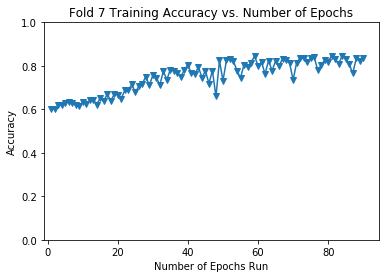

In [209]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_7f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 7 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

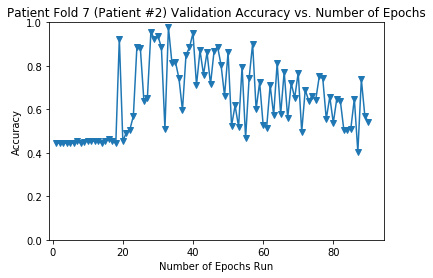

In [210]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_7f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 7 (Patient #2) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [211]:
# Eighth Patient (Patient 3)
graph_seed = 42
reset_graph(graph_seed)

In [212]:
# Eighth Patient (Patient 3)
X_valid_fold = X_sorted[validation_8]
y_valid_fold = y_sorted[validation_8]

In [213]:
X_valid_fold.shape

(200, 380000)

In [214]:
y_valid_fold.shape

(200,)

In [215]:
# Validation Cube for patient fold 8 (Patient #3)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_8_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [216]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [217]:
# Eighth Training Fold (Patients 13,10,1,9,6,2,14,5,8,12,4,7)
X_train_fold = X_sorted[training_8]
y_train_fold = y_sorted[training_8]

In [218]:
X_train_fold.shape

(4175, 380000)

In [219]:
y_train_fold.shape

(4175,)

In [220]:
# Sets the Neural Network for the graph
height = 100
width = 100
channels = 38
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
# 4*4*pool6_fmaps is the size of the output of the last max poll layer
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 4 * 4])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [221]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [222]:
n_iterations_per_epoch

83

In [223]:
# Trains the CNN
acc_train_mat_8f = []
acc_valid_mat_8f = []

y_pred_valid_mat_8f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_8f.append(acc_train)
        acc_valid_mat_8f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_8f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_8f.append(y_pred_valid_8f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./SH_maxdata_baseneta_50tanh_8fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-05 01:46:41.299031 

Epoch 0
Last Batch accuracy:  40.00 %, Training accuracy:  50.28 %, Validation accuracy:  37.50 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  41  seconds.
Epoch 1
Last Batch accuracy:  50.00 %, Training accuracy:  53.05 %, Validation accuracy:  37.50 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  21  seconds.
Epoch 2
Last Batch accuracy:  46.00 %, Training accuracy:  54.87 %, Validation accuracy:  37.50 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  0  seconds.
Epoch 3
Last Batch accuracy:  66.00 %, Training accuracy:  57.75 %, Validation accuracy:  37.50 %
Time training up to Epoch  3 :  0  hours,  2  minutes, and  40  seconds.
Epoch 4
Last Batch accuracy:  72.00 %, Training accuracy:  60.72 %, Validation accuracy:  37.50 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  19  seconds.
Epoch 5
Last Batch accuracy:  56.00 %, Training accuracy:  56.67 %, Validation accuracy:  37.50 %
Time t

Last Batch accuracy:  84.00 %, Training accuracy:  81.84 %, Validation accuracy:  37.50 %
Time training up to Epoch  47 :  0  hours,  31  minutes, and  51  seconds.
Epoch 48
Last Batch accuracy:  80.00 %, Training accuracy:  79.83 %, Validation accuracy:  37.50 %
Time training up to Epoch  48 :  0  hours,  32  minutes, and  31  seconds.
Epoch 49
Last Batch accuracy:  82.00 %, Training accuracy:  80.12 %, Validation accuracy:  37.50 %
Time training up to Epoch  49 :  0  hours,  33  minutes, and  11  seconds.
Epoch 50
Last Batch accuracy:  78.00 %, Training accuracy:  78.66 %, Validation accuracy:  37.50 %
Time training up to Epoch  50 :  0  hours,  33  minutes, and  51  seconds.
Epoch 51
Last Batch accuracy:  86.00 %, Training accuracy:  79.66 %, Validation accuracy:  37.50 %
Time training up to Epoch  51 :  0  hours,  34  minutes, and  31  seconds.
Epoch 52
Last Batch accuracy:  78.00 %, Training accuracy:  80.72 %, Validation accuracy:  37.50 %
Time training up to Epoch  52 :  0  hour

In [224]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Eighth Patient Fold (Patient #3) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Eighth Patient Fold (Patient #3) of CV took 0  hours,  59  minutes, and  38  seconds to train.



In [225]:
valid_accuracy_8f = accuracy_score(y_valid_fold, y_pred_valid_8f)
valid_precision_8f = precision_score(y_valid_fold, y_pred_valid_8f)
valid_recall_8f = recall_score(y_valid_fold, y_pred_valid_8f)
valid_f1_8f = f1_score(y_valid_fold, y_pred_valid_8f)

print("Segment Validation Statistics, Eighth Patient Fold:\nAccuracy:\t\t",valid_accuracy_8f,
      "\nPrecision:\t\t",valid_precision_8f)
print("Recall:\t\t\t",valid_recall_8f,"\nF1 Score:\t\t",valid_f1_8f)

Segment Validation Statistics, Eighth Patient Fold:
Accuracy:		 0.375 
Precision:		 0.0
Recall:			 0.0 
F1 Score:		 0.0


C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [226]:
valid_label = np.unique(y_valid_fold)
validation_cm_8f = confusion_matrix(y_valid_fold, y_pred_valid_8f, labels=valid_label) 

print("Eighth Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_8f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Eighth Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                 75                  0
true:Nonleasional             125                  0


In [227]:
y_valid_cube_pred_8fold = group_hypercube(y_pred_valid_8f, cube_threshold, 
                                          validation_8_key, seg_length, seg_width)

In [228]:
valid_accuracy_cube_8f = accuracy_score(y_valid_cube, y_valid_cube_pred_8fold)
valid_precision_cube_8f = precision_score(y_valid_cube, y_valid_cube_pred_8fold)
valid_recall_cube_8f = recall_score(y_valid_cube, y_valid_cube_pred_8fold)
valid_f1_cube_8f = f1_score(y_valid_cube, y_valid_cube_pred_8fold)

print("Validation Model Hypercube Statistics, Eighth Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_8f,
      "\nHypercube Precision:\t\t",valid_precision_cube_8f)
print("Hypercube Recall: \t\t",valid_recall_cube_8f,"\nHypercube F1 Score:\t\t",valid_f1_cube_8f)

Validation Model Hypercube Statistics, Eighth Patient Fold:
Hypercube Accuracy:		 0.375 
Hypercube Precision:		 0.0
Hypercube Recall: 		 0.0 
Hypercube F1 Score:		 0.0


C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [229]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_8f = confusion_matrix(y_valid_cube, y_valid_cube_pred_8fold, labels=valid_cube_label) 

print("Eighth Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_8f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Eighth Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  3                  0
true:Nonleasional               5                  0


In [230]:
avg_v_acc_8f, avg_v_prec_8f, avg_v_re_8f, avg_v_f1_8f, avg_v_cm_8f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_8f, y_valid_fold)

C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [231]:
print("Average (20 Epochs) Segment Validation Statistics, Eighth Patient Fold:\nAccuracy:\t\t",avg_v_acc_8f,
      "\nPrecision:\t\t",avg_v_prec_8f)
print("Recall:\t\t\t",avg_v_re_8f,"\nF1 Score:\t\t",avg_v_f1_8f)

Average (20 Epochs) Segment Validation Statistics, Eighth Patient Fold:
Accuracy:		 0.375 
Precision:		 0.0
Recall:			 0.0 
F1 Score:		 0.0


In [232]:
avgvalid_cm_8f =  avg_v_cm_8f.groupby(avg_v_cm_8f.index)

avgvalid_cm_8f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,75,0
true:Nonleasional,125,0


In [233]:
avg_vc_acc_8f, avg_vc_prec_8f, avg_vc_re_8f, avg_vc_f1_8f, avg_vc_cm_8f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_8f, 
                                                                                             cube_threshold, 
                                                                                             validation_8_key, 
                                                                                             seg_length, seg_width)
print("Average (20 Epochs) Hypercube Validation Statistics, Eighth Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_8f,
      "\nHypercube Precision:\t\t",avg_vc_prec_8f)
print("Hypercube Recall:\t\t",avg_vc_re_8f,"\nHypercube F1 Score:\t\t",avg_vc_f1_8f)


Average (20 Epochs) Hypercube Validation Statistics, Eighth Patient Fold:
Hypercube Accuracy:		 0.375 
Hypercube Precision:		 0.0
Hypercube Recall:		 0.0 
Hypercube F1 Score:		 0.0


C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [234]:
avgvalid_cm_cube_8f =  avg_vc_cm_8f.groupby(avg_vc_cm_8f.index)

avgvalid_cm_cube_8f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,3,0
true:Nonleasional,5,0


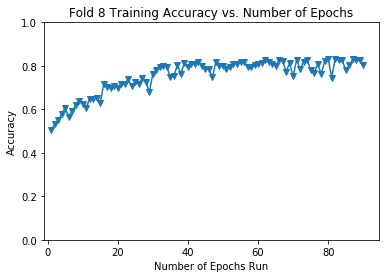

In [235]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_8f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 8 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

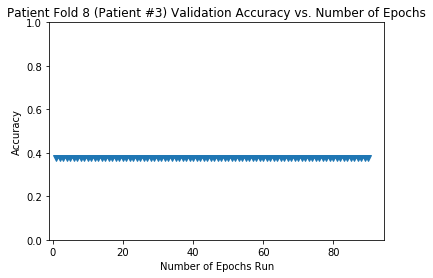

In [236]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_8f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 8 (Patient #3) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [237]:
# Ninth Patient (Patient #6)
graph_seed = 42
reset_graph(graph_seed)

In [238]:
# Ninth Validation Fold (Patient #6)
X_valid_fold = X_sorted[validation_9]
y_valid_fold = y_sorted[validation_9]

In [239]:
X_valid_fold.shape

(250, 380000)

In [240]:
y_valid_fold.shape

(250,)

In [241]:
# Validation Cube for patient fold 9 (Patient #6)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_9_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [242]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [243]:
# Fifth Training Fold (Patients 13,10,1,9,3,2,14,5,8,12,4,7)
X_train_fold = X_sorted[training_9]
y_train_fold = y_sorted[training_9]

In [244]:
X_train_fold.shape

(4125, 380000)

In [245]:
y_train_fold.shape

(4125,)

In [246]:
# Sets the Neural Network for the graph
height = 100
width = 100
channels = 38
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
# 4*4*pool6_fmaps is the size of the output of the last max poll layer
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 4 * 4])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [247]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [248]:
n_iterations_per_epoch

82

In [249]:
# Trains the CNN
acc_train_mat_9f = []
acc_valid_mat_9f = []

y_pred_valid_mat_9f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_9f.append(acc_train)
        acc_valid_mat_9f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_9f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_9f.append(y_pred_valid_9f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./SH_maxdata_baseneta_50tanh_9fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-05 02:47:03.722794 

Epoch 0
Last Batch accuracy:  58.00 %, Training accuracy:  55.78 %, Validation accuracy:  44.00 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  40  seconds.
Epoch 1
Last Batch accuracy:  50.00 %, Training accuracy:  54.67 %, Validation accuracy:  40.40 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  19  seconds.
Epoch 2
Last Batch accuracy:  42.00 %, Training accuracy:  51.98 %, Validation accuracy:  40.00 %
Time training up to Epoch  2 :  0  hours,  1  minutes, and  57  seconds.
Epoch 3
Last Batch accuracy:  48.00 %, Training accuracy:  61.82 %, Validation accuracy:  64.00 %
Time training up to Epoch  3 :  0  hours,  2  minutes, and  36  seconds.
Epoch 4
Last Batch accuracy:  54.00 %, Training accuracy:  53.36 %, Validation accuracy:  40.00 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  15  seconds.
Epoch 5
Last Batch accuracy:  68.00 %, Training accuracy:  56.32 %, Validation accuracy:  43.20 %
Time 

Last Batch accuracy:  78.00 %, Training accuracy:  74.62 %, Validation accuracy:  77.20 %
Time training up to Epoch  48 :  0  hours,  31  minutes, and  29  seconds.
Epoch 49
Last Batch accuracy:  74.00 %, Training accuracy:  79.15 %, Validation accuracy:  69.60 %
Time training up to Epoch  49 :  0  hours,  32  minutes, and  8  seconds.
Epoch 50
Last Batch accuracy:  68.00 %, Training accuracy:  80.68 %, Validation accuracy:  80.80 %
Time training up to Epoch  50 :  0  hours,  32  minutes, and  46  seconds.
Epoch 51
Last Batch accuracy:  82.00 %, Training accuracy:  83.20 %, Validation accuracy:  88.80 %
Time training up to Epoch  51 :  0  hours,  33  minutes, and  25  seconds.
Epoch 52
Last Batch accuracy:  76.00 %, Training accuracy:  81.02 %, Validation accuracy:  70.00 %
Time training up to Epoch  52 :  0  hours,  34  minutes, and  3  seconds.
Epoch 53
Last Batch accuracy:  86.00 %, Training accuracy:  81.50 %, Validation accuracy:  72.80 %
Time training up to Epoch  53 :  0  hours,

In [250]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Ninth Patient Fold (Patient #6) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Ninth Patient Fold (Patient #6) of CV took 0  hours,  57  minutes, and  47  seconds to train.



In [251]:
valid_accuracy_9f = accuracy_score(y_valid_fold, y_pred_valid_9f)
valid_precision_9f = precision_score(y_valid_fold, y_pred_valid_9f)
valid_recall_9f = recall_score(y_valid_fold, y_pred_valid_9f)
valid_f1_9f = f1_score(y_valid_fold, y_pred_valid_9f)

print("Segment Validation Statistics, Ninth Patient Fold:\nAccuracy:\t\t",valid_accuracy_9f,
      "\nPrecision:\t\t",valid_precision_9f)
print("Recall:\t\t\t",valid_recall_9f,"\nF1 Score:\t\t",valid_f1_9f)

Segment Validation Statistics, Ninth Patient Fold:
Accuracy:		 0.888 
Precision:		 0.9919354838709677
Recall:			 0.82 
F1 Score:		 0.8978102189781021


In [252]:
valid_label = np.unique(y_valid_fold)
validation_cm_9f = confusion_matrix(y_valid_fold, y_pred_valid_9f, labels=valid_label) 

print("Ninth Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_9f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Ninth Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                 99                  1
true:Nonleasional              27                123


In [253]:
y_valid_cube_pred_9fold = group_hypercube(y_pred_valid_9f, cube_threshold, 
                                          validation_9_key, seg_length, seg_width)

In [254]:
valid_accuracy_cube_9f = accuracy_score(y_valid_cube, y_valid_cube_pred_9fold)
valid_precision_cube_9f = precision_score(y_valid_cube, y_valid_cube_pred_9fold)
valid_recall_cube_9f = recall_score(y_valid_cube, y_valid_cube_pred_9fold)
valid_f1_cube_9f = f1_score(y_valid_cube, y_valid_cube_pred_9fold)

print("Validation Model Hypercube Statistics, Ninth Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_9f,
      "\nHypercube Precision:\t\t",valid_precision_cube_9f)
print("Hypercube Recall: \t\t",valid_recall_cube_9f,"\nHypercube F1 Score:\t\t",valid_f1_cube_9f)

Validation Model Hypercube Statistics, Ninth Patient Fold:
Hypercube Accuracy:		 0.9 
Hypercube Precision:		 1.0
Hypercube Recall: 		 0.8333333333333334 
Hypercube F1 Score:		 0.9090909090909091


In [255]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_9f = confusion_matrix(y_valid_cube, y_valid_cube_pred_9fold, labels=valid_cube_label) 

print("Ninth Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_9f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Ninth Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  4                  0
true:Nonleasional               1                  5


In [256]:
avg_v_acc_9f, avg_v_prec_9f, avg_v_re_9f, avg_v_f1_9f, avg_v_cm_9f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_9f, y_valid_fold)

In [257]:
print("Average (20 Epochs) Segment Validation Statistics, Ninth Patient Fold:\nAccuracy:\t\t",avg_v_acc_9f,
      "\nPrecision:\t\t",avg_v_prec_9f)
print("Recall:\t\t\t",avg_v_re_9f,"\nF1 Score:\t\t",avg_v_f1_9f)

Average (20 Epochs) Segment Validation Statistics, Ninth Patient Fold:
Accuracy:		 0.8030000000000002 
Precision:		 0.9906315368196494
Recall:			 0.6793333333333333 
F1 Score:		 0.7948344823067839


In [258]:
avgvalid_cm_9f =  avg_v_cm_9f.groupby(avg_v_cm_9f.index)

avgvalid_cm_9f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,98.85,1.15
true:Nonleasional,48.10,101.90


In [259]:
avg_vc_acc_9f, avg_vc_prec_9f, avg_vc_re_9f, avg_vc_f1_9f, avg_vc_cm_9f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_9f, 
                                                                                             cube_threshold, 
                                                                                             validation_9_key, 
                                                                                             seg_length, seg_width)
print("Average (20 Epochs) Hypercube Validation Statistics, Ninth Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_9f,
      "\nHypercube Precision:\t\t",avg_vc_prec_9f)
print("Hypercube Recall:\t\t",avg_vc_re_9f,"\nHypercube F1 Score:\t\t",avg_vc_f1_9f)


Average (20 Epochs) Hypercube Validation Statistics, Ninth Patient Fold:
Hypercube Accuracy:		 0.8150000000000001 
Hypercube Precision:		 1.0
Hypercube Recall:		 0.6916666666666668 
Hypercube F1 Score:		 0.8049999999999999


In [260]:
avgvalid_cm_cube_9f =  avg_vc_cm_9f.groupby(avg_vc_cm_9f.index)

avgvalid_cm_cube_9f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,4.00,0.00
true:Nonleasional,1.85,4.15


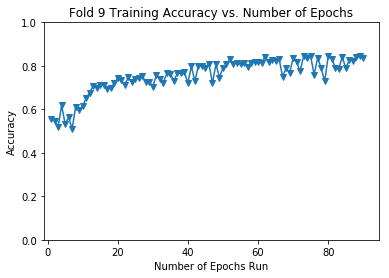

In [261]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_9f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 9 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

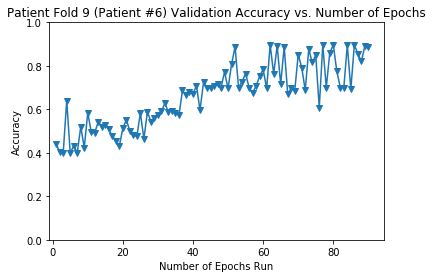

In [262]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_9f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 9 (Patient #6) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [263]:
# Tenth Patient (Patient 9)
graph_seed = 42
reset_graph(graph_seed)

In [264]:
# Tenth Patient Fold (Patient 9)
X_valid_fold = X_sorted[validation_10]
y_valid_fold = y_sorted[validation_10]

In [265]:
X_valid_fold.shape

(375, 380000)

In [266]:
y_valid_fold.shape

(375,)

In [267]:
# Validation Cube for patient fold 10
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_10_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [268]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [269]:
# Tenth Training Fold (Patients 13,10,1,6,3,2,14,5,8,12,4,7)
X_train_fold = X_sorted[training_10]
y_train_fold = y_sorted[training_10]

In [270]:
X_train_fold.shape

(4000, 380000)

In [271]:
y_train_fold.shape

(4000,)

In [272]:
# Sets the Neural Network for the graph
height = 100
width = 100
channels = 38
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
# 4*4*pool6_fmaps is the size of the output of the last max poll layer
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 4 * 4])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [273]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [274]:
n_iterations_per_epoch

80

In [275]:
# Trains the CNN
acc_train_mat_10f = []
acc_valid_mat_10f = []

y_pred_valid_mat_10f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_10f.append(acc_train)
        acc_valid_mat_10f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_10f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_10f.append(y_pred_valid_10f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./SH_maxdata_baseneta_50tanh_10fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-05 03:45:39.363430 

Epoch 0
Last Batch accuracy:  74.00 %, Training accuracy:  61.18 %, Validation accuracy:  39.47 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  37  seconds.
Epoch 1
Last Batch accuracy:  62.00 %, Training accuracy:  56.55 %, Validation accuracy:  39.47 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  14  seconds.
Epoch 2
Last Batch accuracy:  48.00 %, Training accuracy:  52.95 %, Validation accuracy:  43.20 %
Time training up to Epoch  2 :  0  hours,  1  minutes, and  51  seconds.
Epoch 3
Last Batch accuracy:  54.00 %, Training accuracy:  56.17 %, Validation accuracy:  38.40 %
Time training up to Epoch  3 :  0  hours,  2  minutes, and  27  seconds.
Epoch 4
Last Batch accuracy:  62.00 %, Training accuracy:  52.75 %, Validation accuracy:  45.07 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  4  seconds.
Epoch 5
Last Batch accuracy:  56.00 %, Training accuracy:  55.53 %, Validation accuracy:  45.87 %
Time t

Last Batch accuracy:  76.00 %, Training accuracy:  81.38 %, Validation accuracy:  81.07 %
Time training up to Epoch  48 :  0  hours,  30  minutes, and  1  seconds.
Epoch 49
Last Batch accuracy:  86.00 %, Training accuracy:  80.53 %, Validation accuracy:  81.07 %
Time training up to Epoch  49 :  0  hours,  30  minutes, and  38  seconds.
Epoch 50
Last Batch accuracy:  66.00 %, Training accuracy:  77.92 %, Validation accuracy:  73.60 %
Time training up to Epoch  50 :  0  hours,  31  minutes, and  15  seconds.
Epoch 51
Last Batch accuracy:  90.00 %, Training accuracy:  81.55 %, Validation accuracy:  83.20 %
Time training up to Epoch  51 :  0  hours,  31  minutes, and  51  seconds.
Epoch 52
Last Batch accuracy:  90.00 %, Training accuracy:  80.58 %, Validation accuracy:  85.87 %
Time training up to Epoch  52 :  0  hours,  32  minutes, and  28  seconds.
Epoch 53
Last Batch accuracy:  90.00 %, Training accuracy:  80.05 %, Validation accuracy:  77.33 %
Time training up to Epoch  53 :  0  hours

In [276]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Tenth Patient Fold (Patient #9) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Tenth Patient Fold (Patient #9) of CV took 0  hours,  55  minutes, and  12  seconds to train.



In [277]:
valid_accuracy_10f = accuracy_score(y_valid_fold, y_pred_valid_10f)
valid_precision_10f = precision_score(y_valid_fold, y_pred_valid_10f)
valid_recall_10f = recall_score(y_valid_fold, y_pred_valid_10f)
valid_f1_10f = f1_score(y_valid_fold, y_pred_valid_10f)

print("Segment Validation Statistics, Tenth Patient Fold:\nAccuracy:\t\t",valid_accuracy_10f,
      "\nPrecision:\t\t",valid_precision_10f)
print("Recall:\t\t\t",valid_recall_10f,"\nF1 Score:\t\t",valid_f1_10f)

Segment Validation Statistics, Tenth Patient Fold:
Accuracy:		 0.8773333333333333 
Precision:		 0.8347826086956521
Recall:			 0.96 
F1 Score:		 0.8930232558139534


In [278]:
valid_label = np.unique(y_valid_fold)
validation_cm_10f = confusion_matrix(y_valid_fold, y_pred_valid_10f, labels=valid_label) 

print("Tenth Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_10f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Tenth Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                137                 38
true:Nonleasional               8                192


In [279]:
y_valid_cube_pred_10fold = group_hypercube(y_pred_valid_10f, cube_threshold, 
                                           validation_10_key, seg_length, seg_width)

In [280]:
valid_accuracy_cube_10f = accuracy_score(y_valid_cube, y_valid_cube_pred_10fold)
valid_precision_cube_10f = precision_score(y_valid_cube, y_valid_cube_pred_10fold)
valid_recall_cube_10f = recall_score(y_valid_cube, y_valid_cube_pred_10fold)
valid_f1_cube_10f = f1_score(y_valid_cube, y_valid_cube_pred_10fold)

print("Validation Model Hypercube Statistics, Tenth Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_10f,
      "\nHypercube Precision:\t\t",valid_precision_cube_10f)
print("Hypercube Recall: \t\t",valid_recall_cube_10f,"\nHypercube F1 Score:\t\t",valid_f1_cube_10f)

Validation Model Hypercube Statistics, Tenth Patient Fold:
Hypercube Accuracy:		 0.8666666666666667 
Hypercube Precision:		 0.8
Hypercube Recall: 		 1.0 
Hypercube F1 Score:		 0.888888888888889


In [281]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_10f = confusion_matrix(y_valid_cube, y_valid_cube_pred_10fold, labels=valid_cube_label) 

print("Tenth Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_10f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Tenth Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  5                  2
true:Nonleasional               0                  8


In [282]:
avg_v_acc_10f, avg_v_prec_10f, avg_v_re_10f, avg_v_f1_10f, avg_v_cm_10f = average_runs(averaged_runs,
                                                                                       y_pred_valid_mat_10f, y_valid_fold)

In [283]:
print("Average (20 Epochs) Segment Validation Statistics, Tenth Patient Fold:\nAccuracy:\t\t",avg_v_acc_10f,
      "\nPrecision:\t\t",avg_v_prec_10f)
print("Recall:\t\t\t",avg_v_re_10f,"\nF1 Score:\t\t",avg_v_f1_10f)

Average (20 Epochs) Segment Validation Statistics, Tenth Patient Fold:
Accuracy:		 0.8454666666666666 
Precision:		 0.8383951460304848
Recall:			 0.877 
F1 Score:		 0.849280923719397


In [284]:
avgvalid_cm_10f =  avg_v_cm_10f.groupby(avg_v_cm_10f.index)

avgvalid_cm_10f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,141.65,33.35
true:Nonleasional,24.60,175.40


In [285]:
avg_vc_acc_10f, avg_vc_prec_10f, avg_vc_re_10f, avg_vc_f1_10f, avg_vc_cm_10f = average_group_runs(averaged_runs,
                                                                                                  y_valid_cube, 
                                                                                                  y_pred_valid_mat_10f, 
                                                                                                  cube_threshold, 
                                                                                                  validation_10_key, 
                                                                                                  seg_length, seg_width)
print("Average (20 Epochs) Hypercube Validation Statistics, Tenth Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_10f,
      "\nHypercube Precision:\t\t",avg_vc_prec_10f)
print("Hypercube Recall:\t\t",avg_vc_re_10f,"\nHypercube F1 Score:\t\t",avg_vc_f1_10f)


Average (20 Epochs) Hypercube Validation Statistics, Tenth Patient Fold:
Hypercube Accuracy:		 0.86 
Hypercube Precision:		 0.8417658730158731
Hypercube Recall:		 0.90625 
Hypercube F1 Score:		 0.8664627774186598


In [286]:
avgvalid_cm_cube_10f =  avg_vc_cm_10f.groupby(avg_vc_cm_10f.index)

avgvalid_cm_cube_10f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,5.65,1.35
true:Nonleasional,0.75,7.25


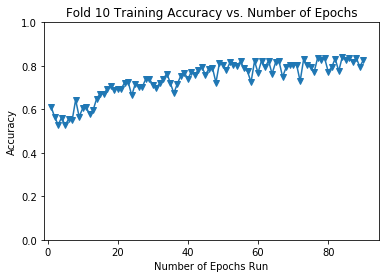

In [287]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_10f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 10 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

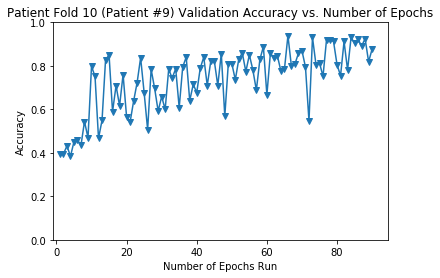

In [288]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_10f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 10 (Patient #9) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [289]:
# Eleventh Patient (Patient 1)
graph_seed = 42
reset_graph(graph_seed)

In [290]:
# Eleventh Validation Fold (Patient 1)
X_valid_fold = X_sorted[validation_11]
y_valid_fold = y_sorted[validation_11]

In [291]:
X_valid_fold.shape

(125, 380000)

In [292]:
y_valid_fold.shape

(125,)

In [293]:
# Validation Cube for patient fold 11
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_11_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [294]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [295]:
# Eleventh Training Fold (Patients 13,10,9,6,3,2,14,5,8,12,4,7)
X_train_fold = X_sorted[training_11]
y_train_fold = y_sorted[training_11]

In [296]:
X_train_fold.shape

(4250, 380000)

In [297]:
y_train_fold.shape

(4250,)

In [298]:
# Sets the Neural Network for the graph
height = 100
width = 100
channels = 38
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
# 4*4*pool6_fmaps is the size of the output of the last max poll layer
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 4 * 4])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [299]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [300]:
n_iterations_per_epoch

85

In [301]:
# Trains the CNN
acc_train_mat_11f = []
acc_valid_mat_11f = []

y_pred_valid_mat_11f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_11f.append(acc_train)
        acc_valid_mat_11f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_11f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_11f.append(y_pred_valid_11f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./SH_maxdata_baseneta_50tanh_11fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-05 04:41:40.179125 

Epoch 0
Last Batch accuracy:  50.00 %, Training accuracy:  59.81 %, Validation accuracy:  100.00 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  40  seconds.
Epoch 1
Last Batch accuracy:  44.00 %, Training accuracy:  52.09 %, Validation accuracy:  75.20 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  22  seconds.
Epoch 2
Last Batch accuracy:  58.00 %, Training accuracy:  50.09 %, Validation accuracy:  60.00 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  2  seconds.
Epoch 3
Last Batch accuracy:  50.00 %, Training accuracy:  56.09 %, Validation accuracy:  99.20 %
Time training up to Epoch  3 :  0  hours,  2  minutes, and  41  seconds.
Epoch 4
Last Batch accuracy:  40.00 %, Training accuracy:  52.47 %, Validation accuracy:  60.00 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  21  seconds.
Epoch 5
Last Batch accuracy:  60.00 %, Training accuracy:  63.13 %, Validation accuracy:  84.80 %
Time 

Last Batch accuracy:  80.00 %, Training accuracy:  81.51 %, Validation accuracy:  53.60 %
Time training up to Epoch  48 :  0  hours,  32  minutes, and  19  seconds.
Epoch 49
Last Batch accuracy:  88.00 %, Training accuracy:  81.36 %, Validation accuracy:  68.00 %
Time training up to Epoch  49 :  0  hours,  32  minutes, and  59  seconds.
Epoch 50
Last Batch accuracy:  76.00 %, Training accuracy:  81.41 %, Validation accuracy:  70.40 %
Time training up to Epoch  50 :  0  hours,  33  minutes, and  38  seconds.
Epoch 51
Last Batch accuracy:  88.00 %, Training accuracy:  81.60 %, Validation accuracy:  67.20 %
Time training up to Epoch  51 :  0  hours,  34  minutes, and  18  seconds.
Epoch 52
Last Batch accuracy:  84.00 %, Training accuracy:  79.58 %, Validation accuracy:  72.00 %
Time training up to Epoch  52 :  0  hours,  34  minutes, and  57  seconds.
Epoch 53
Last Batch accuracy:  82.00 %, Training accuracy:  81.44 %, Validation accuracy:  60.80 %
Time training up to Epoch  53 :  0  hour

In [302]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Eleventh Patient Fold (Patient #1) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Eleventh Patient Fold (Patient #1) of CV took 0  hours,  59  minutes, and  25  seconds to train.



In [303]:
valid_accuracy_11f = accuracy_score(y_valid_fold, y_pred_valid_11f)
valid_precision_11f = precision_score(y_valid_fold, y_pred_valid_11f)
valid_recall_11f = recall_score(y_valid_fold, y_pred_valid_11f)
valid_f1_11f = f1_score(y_valid_fold, y_pred_valid_11f)

print("Segment Validation Statistics, Eleventh Patient Fold:\nAccuracy:\t\t",valid_accuracy_11f,
      "\nPrecision:\t\t",valid_precision_11f)
print("Recall:\t\t\t",valid_recall_11f,"\nF1 Score:\t\t",valid_f1_11f)

Segment Validation Statistics, Eleventh Patient Fold:
Accuracy:		 0.504 
Precision:		 0.3
Recall:			 0.18 
F1 Score:		 0.225


In [304]:
valid_label = np.unique(y_valid_fold)
validation_cm_11f = confusion_matrix(y_valid_fold, y_pred_valid_11f, labels=valid_label) 

print("Eleventh Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_11f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Eleventh Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                 54                 21
true:Nonleasional              41                  9


In [305]:
y_valid_cube_pred_11fold = group_hypercube(y_pred_valid_11f, cube_threshold, 
                                          validation_11_key, seg_length, seg_width)

In [306]:
valid_accuracy_cube_11f = accuracy_score(y_valid_cube, y_valid_cube_pred_11fold)
valid_precision_cube_11f = precision_score(y_valid_cube, y_valid_cube_pred_11fold)
valid_recall_cube_11f = recall_score(y_valid_cube, y_valid_cube_pred_11fold)
valid_f1_cube_11f = f1_score(y_valid_cube, y_valid_cube_pred_11fold)

print("Validation Model Hypercube Statistics, Eleventh Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_11f,
      "\nHypercube Precision:\t\t",valid_precision_cube_11f)
print("Hypercube Recall: \t\t",valid_recall_cube_11f,"\nHypercube F1 Score:\t\t",valid_f1_cube_11f)

Validation Model Hypercube Statistics, Eleventh Patient Fold:
Hypercube Accuracy:		 0.4 
Hypercube Precision:		 0.0
Hypercube Recall: 		 0.0 
Hypercube F1 Score:		 0.0


In [307]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_11f = confusion_matrix(y_valid_cube, y_valid_cube_pred_11fold, labels=valid_cube_label) 

print("Eleventh Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_11f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Eleventh Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  2                  1
true:Nonleasional               2                  0


In [308]:
avg_v_acc_11f, avg_v_prec_11f, avg_v_re_11f, avg_v_f1_11f, avg_v_cm_11f = average_runs(averaged_runs, 
                                                                                       y_pred_valid_mat_11f, y_valid_fold)

In [309]:
print("Average (20 Epochs) Segment Validation Statistics, Eleventh Patient Fold:\nAccuracy:\t\t",avg_v_acc_11f,
      "\nPrecision:\t\t",avg_v_prec_11f)
print("Recall:\t\t\t",avg_v_re_11f,"\nF1 Score:\t\t",avg_v_f1_11f)

Average (20 Epochs) Segment Validation Statistics, Eleventh Patient Fold:
Accuracy:		 0.5852 
Precision:		 0.358295352820073
Recall:			 0.40599999999999997 
F1 Score:		 0.3682131150498515


In [310]:
avgvalid_cm_11f =  avg_v_cm_11f.groupby(avg_v_cm_11f.index)

avgvalid_cm_11f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,52.85,22.15
true:Nonleasional,29.70,20.30


In [311]:
avg_vc_acc_11f, avg_vc_prec_11f, avg_vc_re_11f, avg_vc_f1_11f, avg_vc_cm_11f = average_group_runs(averaged_runs,
                                                                                                  y_valid_cube,
                                                                                                  y_pred_valid_mat_11f,
                                                                                                  cube_threshold, 
                                                                                                  validation_11_key,
                                                                                                  seg_length, seg_width)
print("Average (20 Epochs) Hypercube Validation Statistics, Eleventh Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_11f,
      "\nHypercube Precision:\t\t",avg_vc_prec_11f)
print("Hypercube Recall:\t\t",avg_vc_re_11f,"\nHypercube F1 Score:\t\t",avg_vc_f1_11f)


Average (20 Epochs) Hypercube Validation Statistics, Eleventh Patient Fold:
Hypercube Accuracy:		 0.5900000000000001 
Hypercube Precision:		 0.29166666666666663
Hypercube Recall:		 0.45 
Hypercube F1 Score:		 0.3533333333333334


C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [312]:
avgvalid_cm_cube_11f =  avg_vc_cm_11f.groupby(avg_vc_cm_11f.index)

avgvalid_cm_cube_11f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,2.05,0.95
true:Nonleasional,1.10,0.90


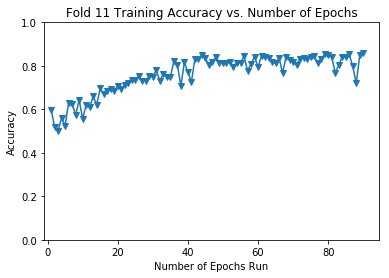

In [313]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_11f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 11 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

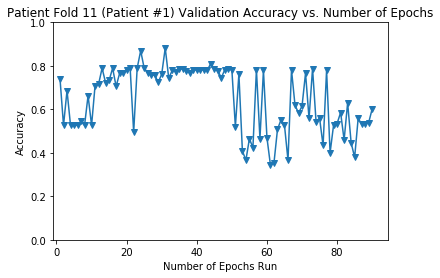

In [314]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_3f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 11 (Patient #1) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [315]:
# Twelfth Patient (Patient #10)
graph_seed = 42
reset_graph(graph_seed)

In [316]:
# Twelfth Validation Fold (Patient #10)
X_valid_fold = X_sorted[validation_12]
y_valid_fold = y_sorted[validation_12]

In [317]:
X_valid_fold.shape

(500, 380000)

In [318]:
y_valid_fold.shape

(500,)

In [319]:
# Validation Cube for patient fold 12 (Patient #10)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_12_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [320]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [321]:
# Fourth Training Fold (Patients 13,1,9,6,3,2,14,5,8,12,4,7)
X_train_fold = X_sorted[training_12]
y_train_fold = y_sorted[training_12]

In [322]:
X_train_fold.shape

(3875, 380000)

In [323]:
y_train_fold.shape

(3875,)

In [324]:
# Sets the Neural Network for the graph
height = 100
width = 100
channels = 38
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
# 4*4*pool6_fmaps is the size of the output of the last max poll layer
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 4 * 4])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [325]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [326]:
n_iterations_per_epoch

77

In [327]:
# Trains the CNN
acc_train_mat_12f = []
acc_valid_mat_12f = []

y_pred_valid_mat_12f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_12f.append(acc_train)
        acc_valid_mat_12f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_12f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_12f.append(y_pred_valid_12f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./SH_maxdata_baseneta_50tanh_12fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-05 05:41:56.451072 

Epoch 0
Last Batch accuracy:  60.00 %, Training accuracy:  54.22 %, Validation accuracy:  45.00 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  37  seconds.
Epoch 1
Last Batch accuracy:  38.00 %, Training accuracy:  51.66 %, Validation accuracy:  45.00 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  14  seconds.
Epoch 2
Last Batch accuracy:  54.00 %, Training accuracy:  50.94 %, Validation accuracy:  45.00 %
Time training up to Epoch  2 :  0  hours,  1  minutes, and  50  seconds.
Epoch 3
Last Batch accuracy:  32.00 %, Training accuracy:  51.51 %, Validation accuracy:  45.00 %
Time training up to Epoch  3 :  0  hours,  2  minutes, and  26  seconds.
Epoch 4
Last Batch accuracy:  44.00 %, Training accuracy:  54.17 %, Validation accuracy:  45.00 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  2  seconds.
Epoch 5
Last Batch accuracy:  42.00 %, Training accuracy:  51.85 %, Validation accuracy:  45.00 %
Time t

Last Batch accuracy:  74.00 %, Training accuracy:  78.06 %, Validation accuracy:  59.40 %
Time training up to Epoch  48 :  0  hours,  29  minutes, and  37  seconds.
Epoch 49
Last Batch accuracy:  72.00 %, Training accuracy:  70.40 %, Validation accuracy:  67.60 %
Time training up to Epoch  49 :  0  hours,  30  minutes, and  13  seconds.
Epoch 50
Last Batch accuracy:  80.00 %, Training accuracy:  73.73 %, Validation accuracy:  71.20 %
Time training up to Epoch  50 :  0  hours,  30  minutes, and  49  seconds.
Epoch 51
Last Batch accuracy:  78.00 %, Training accuracy:  80.05 %, Validation accuracy:  60.80 %
Time training up to Epoch  51 :  0  hours,  31  minutes, and  26  seconds.
Epoch 52
Last Batch accuracy:  84.00 %, Training accuracy:  80.26 %, Validation accuracy:  59.00 %
Time training up to Epoch  52 :  0  hours,  32  minutes, and  2  seconds.
Epoch 53
Last Batch accuracy:  80.00 %, Training accuracy:  82.12 %, Validation accuracy:  62.20 %
Time training up to Epoch  53 :  0  hours

In [328]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Twelfth Patient Fold (Patient #10) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Twelfth Patient Fold (Patient #10) of CV took 0  hours,  54  minutes, and  14  seconds to train.



In [329]:
valid_accuracy_12f = accuracy_score(y_valid_fold, y_pred_valid_12f)
valid_precision_12f = precision_score(y_valid_fold, y_pred_valid_12f)
valid_recall_12f = recall_score(y_valid_fold, y_pred_valid_12f)
valid_f1_12f = f1_score(y_valid_fold, y_pred_valid_12f)

print("Segment Validation Statistics, Twelfth Patient Fold:\nAccuracy:\t\t",valid_accuracy_12f,
      "\nPrecision:\t\t",valid_precision_12f)
print("Recall:\t\t\t",valid_recall_12f,"\nF1 Score:\t\t",valid_f1_12f)

Segment Validation Statistics, Twelfth Patient Fold:
Accuracy:		 0.67 
Precision:		 0.9354838709677419
Recall:			 0.48333333333333334 
F1 Score:		 0.6373626373626374


In [330]:
valid_label = np.unique(y_valid_fold)
validation_cm_12f = confusion_matrix(y_valid_fold, y_pred_valid_12f, labels=valid_label) 

print("Twelfth Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_12f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Twelfth Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                190                 10
true:Nonleasional             155                145


In [331]:
y_valid_cube_pred_12fold = group_hypercube(y_pred_valid_12f, cube_threshold, 
                                          validation_12_key, seg_length, seg_width)

In [332]:
valid_accuracy_cube_12f = accuracy_score(y_valid_cube, y_valid_cube_pred_12fold)
valid_precision_cube_12f = precision_score(y_valid_cube, y_valid_cube_pred_12fold)
valid_recall_cube_12f = recall_score(y_valid_cube, y_valid_cube_pred_12fold)
valid_f1_cube_12f = f1_score(y_valid_cube, y_valid_cube_pred_12fold)

print("Validation Model Hypercube Statistics, Twelfth Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_12f,
      "\nHypercube Precision:\t\t",valid_precision_cube_12f)
print("Hypercube Recall: \t\t",valid_recall_cube_12f,"\nHypercube F1 Score:\t\t",valid_f1_cube_12f)

Validation Model Hypercube Statistics, Twelfth Patient Fold:
Hypercube Accuracy:		 0.65 
Hypercube Precision:		 1.0
Hypercube Recall: 		 0.4166666666666667 
Hypercube F1 Score:		 0.5882352941176471


In [333]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_12f = confusion_matrix(y_valid_cube, y_valid_cube_pred_12fold, labels=valid_cube_label) 

print("Twelfth Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_12f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Twelfth Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  8                  0
true:Nonleasional               7                  5


In [334]:
avg_v_acc_12f, avg_v_prec_12f, avg_v_re_12f, avg_v_f1_12f, avg_v_cm_12f = average_runs(averaged_runs, 
                                                                                       y_pred_valid_mat_12f, y_valid_fold)

In [335]:
print("Average (20 Epochs) Segment Validation Statistics, Twelfth Patient Fold:\nAccuracy:\t\t",avg_v_acc_12f,
      "\nPrecision:\t\t",avg_v_prec_12f)
print("Recall:\t\t\t",avg_v_re_12f,"\nF1 Score:\t\t",avg_v_f1_12f)

Average (20 Epochs) Segment Validation Statistics, Twelfth Patient Fold:
Accuracy:		 0.6990000000000001 
Precision:		 0.9648585710399423
Recall:			 0.5196666666666667 
F1 Score:		 0.6691157093084314


In [336]:
avgvalid_cm_12f =  avg_v_cm_12f.groupby(avg_v_cm_12f.index)

avgvalid_cm_12f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,193.6,6.4
true:Nonleasional,144.1,155.9


In [337]:
avg_vc_acc_12f, avg_vc_prec_12f, avg_vc_re_12f, avg_vc_f1_12f, avg_vc_cm_12f = average_group_runs(averaged_runs,
                                                                                                  y_valid_cube, 
                                                                                                  y_pred_valid_mat_12f,
                                                                                                  cube_threshold, 
                                                                                                  validation_12_key, 
                                                                                                  seg_length, seg_width)
print("Average (20 Epochs) Hypercube Validation Statistics, Twelfth Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_12f,
      "\nHypercube Precision:\t\t",avg_vc_prec_12f)
print("Hypercube Recall:\t\t",avg_vc_re_12f,"\nHypercube F1 Score:\t\t",avg_vc_f1_12f)


Average (20 Epochs) Hypercube Validation Statistics, Twelfth Patient Fold:
Hypercube Accuracy:		 0.7125 
Hypercube Precision:		 0.9777777777777779
Hypercube Recall:		 0.5375 
Hypercube F1 Score:		 0.6797132537225417


In [338]:
avgvalid_cm_cube_12f =  avg_vc_cm_12f.groupby(avg_vc_cm_12f.index)

avgvalid_cm_cube_12f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,7.80,0.20
true:Nonleasional,5.55,6.45


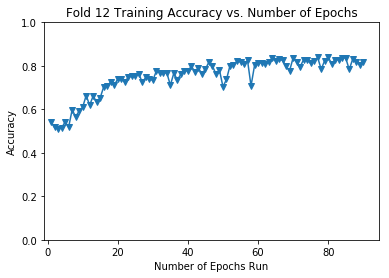

In [339]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_12f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 12 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

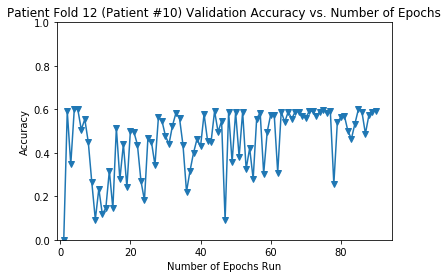

In [340]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_4f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 12 (Patient #10) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [341]:
# Thirteenth Patient (Patient #13)
graph_seed = 42
reset_graph(graph_seed)

In [342]:
# Thirteenth Validation Fold (Patient #13)
X_valid_fold = X_sorted[validation_13]
y_valid_fold = y_sorted[validation_13]

In [343]:
X_valid_fold.shape

(275, 380000)

In [344]:
y_valid_fold.shape

(275,)

In [345]:
# Validation Cube for patient fold 13 (Patient #13)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_13_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [346]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [347]:
# Thirteenth Training Fold (Patients 10,1,9,6,3,2,14,5,8,12,4,7)
X_train_fold = X_sorted[training_13]
y_train_fold = y_sorted[training_13]

In [348]:
X_train_fold.shape

(4100, 380000)

In [349]:
y_train_fold.shape

(4100,)

In [350]:
# Sets the Neural Network for the graph
height = 100
width = 100
channels = 38
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
# 4*4*pool6_fmaps is the size of the output of the last max poll layer
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 4 * 4])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [351]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [352]:
n_iterations_per_epoch

82

In [353]:
# Trains the CNN
acc_train_mat_13f = []
acc_valid_mat_13f = []

y_pred_valid_mat_13f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_13f.append(acc_train)
        acc_valid_mat_13f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_13f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_13f.append(y_pred_valid_13f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./SH_maxdata_baseneta_50tanh_13fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-05 06:36:56.732716 

Epoch 0
Last Batch accuracy:  60.00 %, Training accuracy:  58.98 %, Validation accuracy:  38.91 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  42  seconds.
Epoch 1
Last Batch accuracy:  44.00 %, Training accuracy:  51.10 %, Validation accuracy:  67.27 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  23  seconds.
Epoch 2
Last Batch accuracy:  36.00 %, Training accuracy:  50.10 %, Validation accuracy:  64.00 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  4  seconds.
Epoch 3
Last Batch accuracy:  70.00 %, Training accuracy:  61.63 %, Validation accuracy:  48.73 %
Time training up to Epoch  3 :  0  hours,  2  minutes, and  42  seconds.
Epoch 4
Last Batch accuracy:  60.00 %, Training accuracy:  54.88 %, Validation accuracy:  66.91 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  21  seconds.
Epoch 5
Last Batch accuracy:  56.00 %, Training accuracy:  55.80 %, Validation accuracy:  64.00 %
Time t

Last Batch accuracy:  80.00 %, Training accuracy:  78.34 %, Validation accuracy:  54.18 %
Time training up to Epoch  48 :  0  hours,  31  minutes, and  31  seconds.
Epoch 49
Last Batch accuracy:  76.00 %, Training accuracy:  78.44 %, Validation accuracy:  58.18 %
Time training up to Epoch  49 :  0  hours,  32  minutes, and  9  seconds.
Epoch 50
Last Batch accuracy:  74.00 %, Training accuracy:  78.90 %, Validation accuracy:  60.73 %
Time training up to Epoch  50 :  0  hours,  32  minutes, and  47  seconds.
Epoch 51
Last Batch accuracy:  92.00 %, Training accuracy:  82.63 %, Validation accuracy:  60.73 %
Time training up to Epoch  51 :  0  hours,  33  minutes, and  25  seconds.
Epoch 52
Last Batch accuracy:  78.00 %, Training accuracy:  81.98 %, Validation accuracy:  62.55 %
Time training up to Epoch  52 :  0  hours,  34  minutes, and  3  seconds.
Epoch 53
Last Batch accuracy:  92.00 %, Training accuracy:  81.54 %, Validation accuracy:  66.55 %
Time training up to Epoch  53 :  0  hours,

In [354]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Thirteenth Patient Fold (Patient #13) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Thirteenth Patient Fold (Patient #13) of CV took 0  hours,  57  minutes, and  31  seconds to train.



In [355]:
valid_accuracy_13f = accuracy_score(y_valid_fold, y_pred_valid_13f)
valid_precision_13f = precision_score(y_valid_fold, y_pred_valid_13f)
valid_recall_13f = recall_score(y_valid_fold, y_pred_valid_13f)
valid_f1_13f = f1_score(y_valid_fold, y_pred_valid_13f)

print("Segment Validation Statistics, Thirteenth Patient Fold:\nAccuracy:\t\t",valid_accuracy_13f,
      "\nPrecision:\t\t",valid_precision_13f)
print("Recall:\t\t\t",valid_recall_13f,"\nF1 Score:\t\t",valid_f1_13f)

Segment Validation Statistics, Thirteenth Patient Fold:
Accuracy:		 0.6690909090909091 
Precision:		 0.6266094420600858
Recall:			 0.9733333333333334 
F1 Score:		 0.762402088772846


In [356]:
valid_label = np.unique(y_valid_fold)
validation_cm_13f = confusion_matrix(y_valid_fold, y_pred_valid_13f, labels=valid_label) 

print("Thirteenth Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_13f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Thirteenth Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                 38                 87
true:Nonleasional               4                146


In [357]:
y_valid_cube_pred_13fold = group_hypercube(y_pred_valid_13f, cube_threshold,
                                           validation_13_key, seg_length, seg_width)

In [358]:
valid_accuracy_cube_13f = accuracy_score(y_valid_cube, y_valid_cube_pred_13fold)
valid_precision_cube_13f = precision_score(y_valid_cube, y_valid_cube_pred_13fold)
valid_recall_cube_13f = recall_score(y_valid_cube, y_valid_cube_pred_13fold)
valid_f1_cube_13f = f1_score(y_valid_cube, y_valid_cube_pred_13fold)

print("Validation Model Hypercube Statistics, Thirteenth Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_13f,
      "\nHypercube Precision:\t\t",valid_precision_cube_13f)
print("Hypercube Recall: \t\t",valid_recall_cube_13f,"\nHypercube F1 Score:\t\t",valid_f1_cube_13f)

Validation Model Hypercube Statistics, Thirteenth Patient Fold:
Hypercube Accuracy:		 0.6363636363636364 
Hypercube Precision:		 0.6
Hypercube Recall: 		 1.0 
Hypercube F1 Score:		 0.7499999999999999


In [359]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_13f = confusion_matrix(y_valid_cube, y_valid_cube_pred_13fold, labels=valid_cube_label) 

print("Thirteenth Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_13f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Thirteenth Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  1                  4
true:Nonleasional               0                  6


In [360]:
avg_v_acc_13f, avg_v_prec_13f, avg_v_re_13f, avg_v_f1_13f, avg_v_cm_13f = average_runs(averaged_runs, 
                                                                                       y_pred_valid_mat_13f, y_valid_fold)

In [361]:
print("Average (20 Epochs) Segment Validation Statistics, Thirteenth Patient Fold:\nAccuracy:\t\t",avg_v_acc_13f,
      "\nPrecision:\t\t",avg_v_prec_13f)
print("Recall:\t\t\t",avg_v_re_13f,"\nF1 Score:\t\t",avg_v_f1_13f)

Average (20 Epochs) Segment Validation Statistics, Thirteenth Patient Fold:
Accuracy:		 0.6427272727272727 
Precision:		 0.6104611916867577
Recall:			 0.9786666666666667 
F1 Score:		 0.7504214568887679


In [362]:
avgvalid_cm_13f =  avg_v_cm_13f.groupby(avg_v_cm_13f.index)

avgvalid_cm_13f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,29.95,95.05
true:Nonleasional,3.20,146.80


In [363]:
avg_vc_acc_13f, avg_vc_prec_13f, avg_vc_re_13f, avg_vc_f1_13f, avg_vc_cm_13f = average_group_runs(averaged_runs,
                                                                                                  y_valid_cube, 
                                                                                                  y_pred_valid_mat_13f, 
                                                                                                  cube_threshold, 
                                                                                                  validation_13_key,
                                                                                                  seg_length, seg_width)
print("Average (20 Epochs) Hypercube Validation Statistics, Thirteenth Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_13f,
      "\nHypercube Precision:\t\t",avg_vc_prec_13f)
print("Hypercube Recall:\t\t",avg_vc_re_13f,"\nHypercube F1 Score:\t\t",avg_vc_f1_13f)


Average (20 Epochs) Hypercube Validation Statistics, Thirteenth Patient Fold:
Hypercube Accuracy:		 0.6272727272727273 
Hypercube Precision:		 0.6020400432900432
Hypercube Recall:		 0.9833333333333334 
Hypercube F1 Score:		 0.7440917905623787


In [364]:
avgvalid_cm_cube_13f =  avg_vc_cm_13f.groupby(avg_vc_cm_13f.index)

avgvalid_cm_cube_13f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,1.0,4.0
true:Nonleasional,0.1,5.9


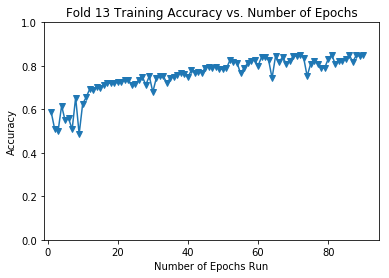

In [365]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_13f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 13 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

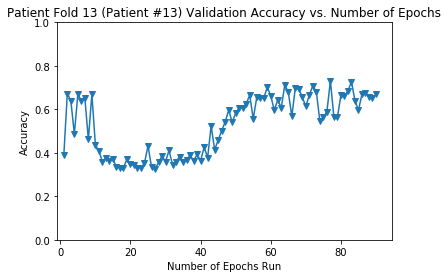

In [366]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_13f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 13 (Patient #13) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [367]:
print('_________________________________________________________________________________________')

_________________________________________________________________________________________


In [368]:
# CV Summary - Validation Segment Statistics
print("Validation Segment Statistics:")
print("Segment Accuracy:")
print("Patient 7:\t", "{0:.6f}".format(valid_accuracy_1f), "\tPatient 4:\t", "{0:.6f}".format(valid_accuracy_2f))
print("Patient 12:\t", "{0:.6f}".format(valid_accuracy_3f), "\tPatient 8:\t", "{0:.6f}".format(valid_accuracy_4f))
print("Patient 5:\t", "{0:.6f}".format(valid_accuracy_5f), "\tPatient 14:\t", "{0:.6f}".format(valid_accuracy_6f))
print("Patient 2:\t", "{0:.6f}".format(valid_accuracy_7f), "\tPatient 3:\t", "{0:.6f}".format(valid_accuracy_8f))
print("Patient 6:\t", "{0:.6f}".format(valid_accuracy_9f), "\tPatient 9:\t", "{0:.6f}".format(valid_accuracy_10f))
print("Patient 1:\t", "{0:.6f}".format(valid_accuracy_11f), "\tPatient 10:\t", "{0:.6f}".format(valid_accuracy_12f))
print("Patient 13:\t", "{0:.6f}".format(valid_accuracy_13f))

val_accuracy_total = (valid_accuracy_1f+valid_accuracy_2f+valid_accuracy_3f+valid_accuracy_4f+valid_accuracy_5f+
                      valid_accuracy_6f+valid_accuracy_7f+valid_accuracy_8f+valid_accuracy_9f+valid_accuracy_10f+
                      valid_accuracy_11f+valid_accuracy_12f+valid_accuracy_13f)
val_accuracy_average = val_accuracy_total/13

print("Average Segment Accuracy:\t", val_accuracy_average)

Validation Segment Statistics:
Segment Accuracy:
Patient 7:	 0.295238 	Patient 4:	 0.840000
Patient 12:	 0.602105 	Patient 8:	 0.592000
Patient 5:	 0.537778 	Patient 14:	 0.916000
Patient 2:	 0.542222 	Patient 3:	 0.375000
Patient 6:	 0.888000 	Patient 9:	 0.877333
Patient 1:	 0.504000 	Patient 10:	 0.670000
Patient 13:	 0.669091
Average Segment Accuracy:	 0.6391359692938642


In [369]:
print("Segment Precision:")
print("Patient 7:\t", "{0:.6f}".format(valid_precision_1f), "\tPatient 4:\t", "{0:.6f}".format(valid_precision_2f))
print("Patient 12:\t", "{0:.6f}".format(valid_precision_3f), "\tPatient 8:\t", "{0:.6f}".format(valid_precision_4f))
print("Patient 5:\t", "{0:.6f}".format(valid_precision_5f), "\tPatient 14:\t", "{0:.6f}".format(valid_precision_6f))
print("Patient 2:\t", "{0:.6f}".format(valid_precision_7f), "\tPatient 3:\t", "{0:.6f}".format(valid_precision_8f))
print("Patient 6:\t", "{0:.6f}".format(valid_precision_9f), "\tPatient 9:\t", "{0:.6f}".format(valid_precision_10f))
print("Patient 1:\t", "{0:.6f}".format(valid_precision_11f), "\tPatient 10:\t", "{0:.6f}".format(valid_precision_12f))
print("Patient 13:\t", "{0:.6f}".format(valid_precision_13f))

val_precision_total = (valid_precision_1f+valid_precision_2f+valid_precision_3f+valid_precision_4f+valid_precision_5f+
                       valid_precision_6f+valid_precision_7f+valid_precision_8f+valid_precision_9f+valid_precision_10f+
                       valid_precision_11f+valid_precision_12f+valid_precision_13f)
val_precision_average = val_precision_total/13

print("Average Segment Precision:\t", val_precision_average)

Segment Precision:
Patient 7:	 0.210526 	Patient 4:	 1.000000
Patient 12:	 0.584112 	Patient 8:	 0.000000
Patient 5:	 0.623188 	Patient 14:	 1.000000
Patient 2:	 0.492228 	Patient 3:	 0.000000
Patient 6:	 0.991935 	Patient 9:	 0.834783
Patient 1:	 0.300000 	Patient 10:	 0.935484
Patient 13:	 0.626609
Average Segment Precision:	 0.5845281735375649


In [370]:
print("Segment Recall:")
print("Patient 7:\t", "{0:.6f}".format(valid_recall_1f), "\tPatient 4:\t", "{0:.6f}".format(valid_recall_2f))
print("Patient 12:\t", "{0:.6f}".format(valid_recall_3f), "\tPatient 8:\t", "{0:.6f}".format(valid_recall_4f))
print("Patient 5:\t", "{0:.6f}".format(valid_recall_5f), "\tPatient 14:\t", "{0:.6f}".format(valid_recall_6f))
print("Patient 2:\t", "{0:.6f}".format(valid_recall_7f), "\tPatient 3:\t", "{0:.6f}".format(valid_recall_8f))
print("Patient 6:\t", "{0:.6f}".format(valid_recall_9f), "\tPatient 9:\t", "{0:.6f}".format(valid_recall_10f))
print("Patient 1:\t", "{0:.6f}".format(valid_recall_11f), "\tPatient 10:\t", "{0:.6f}".format(valid_recall_12f))
print("Patient 13:\t", "{0:.6f}".format(valid_recall_13f))

val_recall_total = (valid_recall_1f+valid_recall_2f+valid_recall_3f+valid_recall_4f+valid_recall_5f+
                    valid_recall_6f+valid_recall_7f+valid_recall_8f+valid_recall_9f+valid_recall_10f+
                    valid_recall_11f+valid_recall_12f+valid_recall_13f)
val_recall_average = val_recall_total/13

print("Average Segment Recall:\t", val_recall_average)

Segment Recall:
Patient 7:	 0.533333 	Patient 4:	 0.626667
Patient 12:	 0.555556 	Patient 8:	 0.000000
Patient 5:	 0.191111 	Patient 14:	 0.895000
Patient 2:	 0.950000 	Patient 3:	 0.000000
Patient 6:	 0.820000 	Patient 9:	 0.960000
Patient 1:	 0.180000 	Patient 10:	 0.483333
Patient 13:	 0.973333
Average Segment Recall:	 0.5514102564102564


In [371]:
print("Segment F1 Score:")
print("Patient 7:\t", "{0:.6f}".format(valid_f1_1f), "\tPatient 4:\t", "{0:.6f}".format(valid_f1_2f))
print("Patient 12:\t", "{0:.6f}".format(valid_f1_3f), "\tPatient 8:\t", "{0:.6f}".format(valid_f1_4f))
print("Patient 5:\t", "{0:.6f}".format(valid_f1_5f), "\tPatient 14:\t", "{0:.6f}".format(valid_f1_6f))
print("Patient 2:\t", "{0:.6f}".format(valid_f1_7f), "\tPatient 3:\t", "{0:.6f}".format(valid_f1_8f))
print("Patient 6:\t", "{0:.6f}".format(valid_f1_9f), "\tPatient 9:\t", "{0:.6f}".format(valid_f1_10f))
print("Patient 1:\t", "{0:.6f}".format(valid_f1_11f), "\tPatient 10:\t", "{0:.6f}".format(valid_f1_12f))
print("Patient 13:\t", "{0:.6f}".format(valid_f1_13f))

val_f1_total = (valid_f1_1f+valid_f1_2f+valid_f1_3f+valid_f1_4f+valid_f1_5f+valid_f1_6f+valid_f1_7f+
                valid_f1_8f+valid_f1_9f+valid_f1_10f+valid_f1_11f+valid_f1_12f+valid_f1_13f)
val_f1_average = val_f1_total/13

print("Average Segment F1 Score:\t", val_f1_average)

Segment F1 Score:
Patient 7:	 0.301887 	Patient 4:	 0.770492
Patient 12:	 0.569476 	Patient 8:	 0.000000
Patient 5:	 0.292517 	Patient 14:	 0.944591
Patient 2:	 0.648464 	Patient 3:	 0.000000
Patient 6:	 0.897810 	Patient 9:	 0.893023
Patient 1:	 0.225000 	Patient 10:	 0.637363
Patient 13:	 0.762402
Average Segment F1 Score:	 0.5340788521778929


In [372]:
valid_pd_cm_1f = pd.DataFrame(validation_cm_1f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_2f = pd.DataFrame(validation_cm_2f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_3f = pd.DataFrame(validation_cm_3f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_4f = pd.DataFrame(validation_cm_4f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_5f = pd.DataFrame(validation_cm_5f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_6f = pd.DataFrame(validation_cm_6f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_7f = pd.DataFrame(validation_cm_7f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_8f = pd.DataFrame(validation_cm_8f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_9f = pd.DataFrame(validation_cm_9f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_10f = pd.DataFrame(validation_cm_10f, index=['true:Leasional', 'true:Nonleasional'], 
                               columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_11f = pd.DataFrame(validation_cm_11f, index=['true:Leasional', 'true:Nonleasional'], 
                               columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_12f = pd.DataFrame(validation_cm_12f, index=['true:Leasional', 'true:Nonleasional'], 
                               columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_13f = pd.DataFrame(validation_cm_13f, index=['true:Leasional', 'true:Nonleasional'], 
                               columns=['pred:Leasional', 'pred:Nonleasional'])

In [373]:
# Sum Segment Validation Confusion Matrix
valid_concat = pd.concat((valid_pd_cm_1f,valid_pd_cm_2f,valid_pd_cm_3f,valid_pd_cm_4f,valid_pd_cm_5f,
                          valid_pd_cm_6f,valid_pd_cm_7f,valid_pd_cm_8f,valid_pd_cm_9f,valid_pd_cm_10f,
                          valid_pd_cm_11f,valid_pd_cm_12f,valid_pd_cm_13f))
validation_cm_group =  valid_concat.groupby(valid_concat.index)

validation_cm_group.sum()

,pred:Leasional,pred:Nonleasional
true:Leasional,1527,673
true:Nonleasional,944,1231


In [374]:
y_segment_total = np.array([],dtype=np.int16)
y_segment_total = np.append(y_segment_total, y_pred_valid_13f)
y_segment_total = np.append(y_segment_total, y_pred_valid_12f)
y_segment_total = np.append(y_segment_total, y_pred_valid_11f)
y_segment_total = np.append(y_segment_total, y_pred_valid_10f)
y_segment_total = np.append(y_segment_total, y_pred_valid_9f)
y_segment_total = np.append(y_segment_total, y_pred_valid_8f)
y_segment_total = np.append(y_segment_total, y_pred_valid_7f)
y_segment_total = np.append(y_segment_total, y_pred_valid_6f)
y_segment_total = np.append(y_segment_total, y_pred_valid_5f)
y_segment_total = np.append(y_segment_total, y_pred_valid_4f)
y_segment_total = np.append(y_segment_total, y_pred_valid_3f)
y_segment_total = np.append(y_segment_total, y_pred_valid_2f)
y_segment_total = np.append(y_segment_total, y_pred_valid_1f)


In [375]:
valid_accuracy_overall = accuracy_score(y_sorted,y_segment_total)
valid_precision_overall = precision_score(y_sorted, y_segment_total)
valid_recall_overall = recall_score(y_sorted, y_segment_total)
valid_f1_overall = f1_score(y_sorted, y_segment_total)

print("Segment Validation Statistics, Overall Segment Statistics:\nAccuracy:\t\t",valid_accuracy_overall,
      "\nPrecision:\t\t",valid_precision_overall)
print("Recall:\t\t\t",valid_recall_overall,"\nF1 Score:\t\t",valid_f1_overall)

Segment Validation Statistics, Overall Segment Statistics:
Accuracy:		 0.6304 
Precision:		 0.6465336134453782
Recall:			 0.5659770114942528 
F1 Score:		 0.6035793086540818


In [376]:
print('_________________________________________________________________________________________')

_________________________________________________________________________________________


In [377]:
# CV Summary - Validation Segment Statistics (Averaged over the last 20 epochs)
print("Validation Segment Statistics:")
print("Segment Accuracy (Averaged over the last 20 epochs):")
print("Patient 7:\t", "{0:.6f}".format(avg_v_acc_1f), "\tPatient 4:\t", "{0:.6f}".format(avg_v_acc_2f))
print("Patient 12:\t", "{0:.6f}".format(avg_v_acc_3f), "\tPatient 8:\t", "{0:.6f}".format(avg_v_acc_4f))
print("Patient 5:\t", "{0:.6f}".format(avg_v_acc_5f), "\tPatient 14:\t", "{0:.6f}".format(avg_v_acc_6f))
print("Patient 2:\t", "{0:.6f}".format(avg_v_acc_7f), "\tPatient 3:\t", "{0:.6f}".format(avg_v_acc_8f))
print("Patient 6:\t", "{0:.6f}".format(avg_v_acc_9f), "\tPatient 9:\t", "{0:.6f}".format(avg_v_acc_10f))
print("Patient 1:\t", "{0:.6f}".format(avg_v_acc_11f), "\tPatient 10:\t", "{0:.6f}".format(avg_v_acc_12f))
print("Patient 13:\t", "{0:.6f}".format(avg_v_acc_13f))

avg_val_accuracy_total = (avg_v_acc_1f+avg_v_acc_2f+avg_v_acc_3f+avg_v_acc_4f+avg_v_acc_5f+avg_v_acc_6f+
                          avg_v_acc_7f+avg_v_acc_8f+avg_v_acc_9f+avg_v_acc_10f+avg_v_acc_11f+avg_v_acc_12f+
                          avg_v_acc_13f)
avg_val_accuracy_average = avg_val_accuracy_total/13

print("Average of Segment Accuracy Averages:\t", avg_val_accuracy_average)

Validation Segment Statistics:
Segment Accuracy (Averaged over the last 20 epochs):
Patient 7:	 0.351429 	Patient 4:	 0.814714
Patient 12:	 0.558421 	Patient 8:	 0.547067
Patient 5:	 0.552111 	Patient 14:	 0.870400
Patient 2:	 0.616000 	Patient 3:	 0.375000
Patient 6:	 0.803000 	Patient 9:	 0.845467
Patient 1:	 0.585200 	Patient 10:	 0.699000
Patient 13:	 0.642727
Average of Segment Accuracy Averages:	 0.6354258174573965


In [378]:
print("Segment Precision (Averaged over the last 20 epochs):")
print("Patient 7:\t", "{0:.6f}".format(avg_v_prec_1f), "\tPatient 4:\t", "{0:.6f}".format(avg_v_prec_2f))
print("Patient 12:\t", "{0:.6f}".format(avg_v_prec_3f), "\tPatient 8:\t", "{0:.6f}".format(avg_v_prec_4f))
print("Patient 5:\t", "{0:.6f}".format(avg_v_prec_5f), "\tPatient 14:\t", "{0:.6f}".format(avg_v_prec_6f))
print("Patient 2:\t", "{0:.6f}".format(avg_v_prec_7f), "\tPatient 3:\t", "{0:.6f}".format(avg_v_prec_8f))
print("Patient 6:\t", "{0:.6f}".format(avg_v_prec_9f), "\tPatient 9:\t", "{0:.6f}".format(avg_v_prec_10f))
print("Patient 1:\t", "{0:.6f}".format(avg_v_prec_11f), "\tPatient 10:\t", "{0:.6f}".format(avg_v_prec_12f))
print("Patient 13:\t", "{0:.6f}".format(avg_v_prec_13f))

avg_val_precision_total = (avg_v_prec_1f+avg_v_prec_2f+avg_v_prec_3f+avg_v_prec_4f+avg_v_prec_5f+
                           avg_v_prec_6f+avg_v_prec_7f+avg_v_prec_8f+avg_v_prec_9f+avg_v_prec_10f+
                           avg_v_prec_11f+avg_v_prec_12f+avg_v_prec_13f)
avg_val_precision_average = avg_val_precision_total/13

print("Average of Segment Percision Averages:\t", avg_val_precision_average)

Segment Precision (Averaged over the last 20 epochs):
Patient 7:	 0.278002 	Patient 4:	 0.956553
Patient 12:	 0.574109 	Patient 8:	 0.000000
Patient 5:	 0.578353 	Patient 14:	 0.990131
Patient 2:	 0.600021 	Patient 3:	 0.000000
Patient 6:	 0.990632 	Patient 9:	 0.838395
Patient 1:	 0.358295 	Patient 10:	 0.964859
Patient 13:	 0.610461
Average of Segment Percision Averages:	 0.5953701563308456


In [379]:
print("Segment Recall (Averaged over the last 20 epochs):")
print("Patient 7:\t", "{0:.6f}".format(avg_v_re_1f), "\tPatient 4:\t", "{0:.6f}".format(avg_v_re_2f))
print("Patient 12:\t", "{0:.6f}".format(avg_v_re_3f), "\tPatient 8:\t", "{0:.6f}".format(avg_v_re_4f))
print("Patient 5:\t", "{0:.6f}".format(avg_v_re_5f), "\tPatient 14:\t", "{0:.6f}".format(avg_v_re_6f))
print("Patient 2:\t", "{0:.6f}".format(avg_v_re_7f), "\tPatient 3:\t", "{0:.6f}".format(avg_v_re_8f))
print("Patient 6:\t", "{0:.6f}".format(avg_v_re_9f), "\tPatient 9:\t", "{0:.6f}".format(avg_v_re_10f))
print("Patient 1:\t", "{0:.6f}".format(avg_v_re_11f), "\tPatient 10:\t", "{0:.6f}".format(avg_v_re_12f))
print("Patient 13:\t", "{0:.6f}".format(avg_v_re_13f))

avg_val_recall_total = (avg_v_re_1f+avg_v_re_2f+avg_v_re_3f+avg_v_re_4f+avg_v_re_5f+avg_v_re_6f+
                        avg_v_re_7f+avg_v_re_8f+avg_v_re_9f+avg_v_re_10f+avg_v_re_11f+avg_v_re_12f+
                        avg_v_re_13f)
avg_val_recall_average = avg_val_recall_total/13

print("Average of Segment Recall Averages:\t", avg_val_recall_average)

Segment Recall (Averaged over the last 20 epochs):
Patient 7:	 0.848333 	Patient 4:	 0.596000
Patient 12:	 0.555111 	Patient 8:	 0.000000
Patient 5:	 0.307111 	Patient 14:	 0.847500
Patient 2:	 0.734000 	Patient 3:	 0.000000
Patient 6:	 0.679333 	Patient 9:	 0.877000
Patient 1:	 0.406000 	Patient 10:	 0.519667
Patient 13:	 0.978667
Average of Segment Recall Averages:	 0.5652863247863247


In [380]:
print("Segment F1 Score (Averaged over the last 20 epochs):")
print("Patient 7:\t", "{0:.6f}".format(avg_v_f1_1f), "\tPatient 4:\t", "{0:.6f}".format(avg_v_f1_2f))
print("Patient 12:\t", "{0:.6f}".format(avg_v_f1_3f), "\tPatient 8:\t", "{0:.6f}".format(avg_v_f1_4f))
print("Patient 5:\t", "{0:.6f}".format(avg_v_f1_5f), "\tPatient 14:\t", "{0:.6f}".format(avg_v_f1_6f))
print("Patient 2:\t", "{0:.6f}".format(avg_v_f1_7f), "\tPatient 3:\t", "{0:.6f}".format(avg_v_f1_8f))
print("Patient 6:\t", "{0:.6f}".format(avg_v_f1_9f), "\tPatient 9:\t", "{0:.6f}".format(avg_v_f1_10f))
print("Patient 1:\t", "{0:.6f}".format(avg_v_f1_11f), "\tPatient 10:\t", "{0:.6f}".format(avg_v_f1_12f))
print("Patient 13:\t", "{0:.6f}".format(avg_v_f1_13f))

avg_val_f1_total = (avg_v_f1_1f+avg_v_f1_2f+avg_v_f1_3f+avg_v_f1_4f+avg_v_f1_5f+avg_v_f1_6f+
                    avg_v_f1_7f+avg_v_f1_8f+avg_v_f1_9f+avg_v_f1_10f+avg_v_f1_11f+avg_v_f1_12f+
                    avg_v_f1_13f)
avg_val_f1_average = avg_val_f1_total/13

print("Average of Segment F1 Averages:\t", avg_val_f1_average)

Segment F1 Score (Averaged over the last 20 epochs):
Patient 7:	 0.418134 	Patient 4:	 0.733571
Patient 12:	 0.551513 	Patient 8:	 0.000000
Patient 5:	 0.383683 	Patient 14:	 0.910472
Patient 2:	 0.624823 	Patient 3:	 0.000000
Patient 6:	 0.794834 	Patient 9:	 0.849281
Patient 1:	 0.368213 	Patient 10:	 0.669116
Patient 13:	 0.750421
Average of Segment F1 Averages:	 0.542620202187006


In [381]:
# Average Segment Validation Confusion Matrix (Averaged over the last 20 epochs)
avg_valid_concat = pd.concat((avg_v_cm_1f,avg_v_cm_2f,avg_v_cm_3f,avg_v_cm_4f,avg_v_cm_5f,
                              avg_v_cm_6f,avg_v_cm_7f,avg_v_cm_8f,avg_v_cm_9f,avg_v_cm_10f,
                              avg_v_cm_11f,avg_v_cm_12f,avg_v_cm_13f))
avg_validation_cm_group =  avg_valid_concat.groupby(avg_valid_concat.index)

avg_validation_cm_group.sum()/20

,pred:Leasional,pred:Nonleasional
true:Leasional,1483.05,716.95
true:Nonleasional,921.15,1253.85


In [382]:
start_avg=epoch-averaged_runs

y_avg_seg_total_mat = np.array([],dtype=np.int16)

y_avg_seg_total = np.array([],dtype=np.int16)
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_13f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_12f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_11f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_10f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_9f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_8f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_7f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_6f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_5f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_4f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_3f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_2f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_1f[start_avg])
y_avg_seg_total_mat = np.append(y_avg_seg_total_mat, y_avg_seg_total)

for index in range(start_avg+1,epoch):
    y_avg_seg_total = np.array([],dtype=np.int16)
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_13f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_12f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_11f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_10f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_9f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_8f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_7f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_6f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_5f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_4f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_3f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_2f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_1f[index])
    y_avg_seg_total_mat = np.vstack((y_avg_seg_total_mat, y_avg_seg_total))

In [383]:
over_acc_mat = np.array([],dtype=np.int16)
over_prec_mat = np.array([],dtype=np.int16)
over_recall_mat = np.array([],dtype=np.int16)
over_f1_mat = np.array([],dtype=np.int16)
over_confuse_mat = []
for i in range(20):
    index_acc = accuracy_score(y_sorted, y_avg_seg_total_mat[i])
    over_acc_mat = np.append(over_acc_mat, index_acc)
    index_prec = precision_score(y_sorted, y_avg_seg_total_mat[i])
    over_prec_mat = np.append(over_prec_mat, index_prec)        
    index_recall = recall_score(y_sorted, y_avg_seg_total_mat[i])
    over_recall_mat = np.append(over_recall_mat, index_recall)        
    index_f1 = f1_score(y_sorted, y_avg_seg_total_mat[i])
    over_f1_mat = np.append(over_f1_mat, index_f1)
    cm_label = np.unique(y_sorted)
    index_cm = confusion_matrix(y_sorted, y_avg_seg_total_mat[i], labels=cm_label)
    pd_cm = pd.DataFrame(index_cm, index=['true:Leasional', 'true:Nonleasional'], 
                         columns=['pred:Leasional', 'pred:Nonleasional'])
    over_confuse_mat.append(pd_cm)
over_seg_avg_acc = np.mean(over_acc_mat)
over_seg_avg_prec = np.mean(over_prec_mat)
over_seg_avg_recall = np.mean(over_recall_mat)
over_seg_avg_f1 = np.mean(over_f1_mat)
over_seg_avg_cm = pd.concat(over_confuse_mat)

In [384]:
print("Average Validation Segment Statistics (Over 20 Epochs), Overall Segment Statistics:\nAccuracy:\t\t",over_seg_avg_acc,
      "\nPrecision:\t\t",over_seg_avg_prec)
print("Recall:\t\t\t",over_seg_avg_recall,"\nF1 Score:\t\t",over_seg_avg_f1)

Average Validation Segment Statistics (Over 20 Epochs), Overall Segment Statistics:
Accuracy:		 0.6255771428571428 
Precision:		 0.6371277011870282
Recall:			 0.5764827586206897 
F1 Score:		 0.6049271294652189


In [385]:
over_seg_avg_cm =  over_seg_avg_cm.groupby(over_seg_avg_cm.index)

over_seg_avg_cm.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,1483.05,716.95
true:Nonleasional,921.15,1253.85


In [386]:
print('_________________________________________________________________________________________')

_________________________________________________________________________________________


In [387]:
# CV Summary - Validation Hypercube Statistics
print("Validation Hypercube Statistics:")
print("Hypercube Accuracy:")
print("Patient 7:\t", "{0:.6f}".format(valid_accuracy_cube_1f), "\tPatient 4:\t", "{0:.6f}".format(valid_accuracy_cube_2f))
print("Patient 12:\t", "{0:.6f}".format(valid_accuracy_cube_3f), "\tPatient 8:\t", "{0:.6f}".format(valid_accuracy_cube_4f))
print("Patient 5:\t", "{0:.6f}".format(valid_accuracy_cube_5f), "\tPatient 14:\t", "{0:.6f}".format(valid_accuracy_cube_6f))
print("Patient 2:\t", "{0:.6f}".format(valid_accuracy_cube_7f), "\tPatient 3:\t", "{0:.6f}".format(valid_accuracy_cube_8f))
print("Patient 6:\t", "{0:.6f}".format(valid_accuracy_cube_9f), "\tPatient 9:\t", "{0:.6f}".format(valid_accuracy_cube_10f))
print("Patient 1:\t", "{0:.6f}".format(valid_accuracy_cube_11f), "\tPatient 10:\t", "{0:.6f}".format(valid_accuracy_cube_12f))
print("Patient 13:\t", "{0:.6f}".format(valid_accuracy_cube_13f))

val_accuracy_cube_total = (valid_accuracy_cube_1f+valid_accuracy_cube_2f+valid_accuracy_cube_3f+
                           valid_accuracy_cube_4f+valid_accuracy_cube_5f+valid_accuracy_cube_6f+
                           valid_accuracy_cube_7f+valid_accuracy_cube_8f+valid_accuracy_cube_9f+
                           valid_accuracy_cube_10f+valid_accuracy_cube_11f+valid_accuracy_cube_12f+
                           valid_accuracy_cube_13f)
val_accuracy_cube_average = val_accuracy_cube_total/13

print("Average Hypercube Accuracy:\t", val_accuracy_cube_average)

Validation Hypercube Statistics:
Hypercube Accuracy:
Patient 7:	 0.333333 	Patient 4:	 0.857143
Patient 12:	 0.631579 	Patient 8:	 0.600000
Patient 5:	 0.555556 	Patient 14:	 0.900000
Patient 2:	 0.555556 	Patient 3:	 0.375000
Patient 6:	 0.900000 	Patient 9:	 0.866667
Patient 1:	 0.400000 	Patient 10:	 0.650000
Patient 13:	 0.636364
Average Hypercube Accuracy:	 0.635476657845079


In [388]:
print("Hypercube Precision:")
print("Patient 7:\t", "{0:.6f}".format(valid_precision_cube_1f), "\tPatient 4:\t", "{0:.6f}".format(valid_precision_cube_2f))
print("Patient 12:\t", "{0:.6f}".format(valid_precision_cube_3f), "\tPatient 8:\t", "{0:.6f}".format(valid_precision_cube_4f))
print("Patient 5:\t", "{0:.6f}".format(valid_precision_cube_5f), "\tPatient 14:\t", "{0:.6f}".format(valid_precision_cube_6f))
print("Patient 2:\t", "{0:.6f}".format(valid_precision_cube_7f), "\tPatient 3:\t", "{0:.6f}".format(valid_precision_cube_8f))
print("Patient 6:\t", "{0:.6f}".format(valid_precision_cube_9f), "\tPatient 9:\t", "{0:.6f}".format(valid_precision_cube_10f))
print("Patient 1:\t", "{0:.6f}".format(valid_precision_cube_11f), "\tPatient 10:\t", "{0:.6f}".format(valid_precision_cube_12f))
print("Patient 13:\t", "{0:.6f}".format(valid_precision_cube_13f))

val_precision_cube_total = (valid_precision_cube_1f+valid_precision_cube_2f+valid_precision_cube_3f+
                            valid_precision_cube_4f+valid_precision_cube_5f+valid_precision_cube_6f+
                            valid_precision_cube_7f+valid_precision_cube_8f+valid_precision_cube_9f+
                            valid_precision_cube_10f+valid_precision_cube_11f+valid_precision_cube_12f+
                            valid_precision_cube_13f)
val_precision_cube_average = val_precision_cube_total/13

print("Average Hypercube Precision:\t", val_precision_cube_average)

Hypercube Precision:
Patient 7:	 0.250000 	Patient 4:	 1.000000
Patient 12:	 0.625000 	Patient 8:	 0.000000
Patient 5:	 0.666667 	Patient 14:	 1.000000
Patient 2:	 0.500000 	Patient 3:	 0.000000
Patient 6:	 1.000000 	Patient 9:	 0.800000
Patient 1:	 0.000000 	Patient 10:	 1.000000
Patient 13:	 0.600000
Average Hypercube Precision:	 0.5724358974358974


In [389]:
print("Hypercube Recall:")
print("Patient 7:\t", "{0:.6f}".format(valid_recall_cube_1f), "\tPatient 4:\t", "{0:.6f}".format(valid_recall_cube_2f))
print("Patient 12:\t", "{0:.6f}".format(valid_recall_cube_3f), "\tPatient 8:\t", "{0:.6f}".format(valid_recall_cube_4f))
print("Patient 5:\t", "{0:.6f}".format(valid_recall_cube_5f), "\tPatient 14:\t", "{0:.6f}".format(valid_recall_cube_6f))
print("Patient 2:\t", "{0:.6f}".format(valid_recall_cube_7f), "\tPatient 3:\t", "{0:.6f}".format(valid_recall_cube_8f))
print("Patient 6:\t", "{0:.6f}".format(valid_recall_cube_9f), "\tPatient 9:\t", "{0:.6f}".format(valid_recall_cube_10f))
print("Patient 1:\t", "{0:.6f}".format(valid_recall_cube_11f), "\tPatient 10:\t", "{0:.6f}".format(valid_recall_cube_12f))
print("Patient 13:\t", "{0:.6f}".format(valid_recall_cube_13f))

val_recall_cube_total = (valid_recall_cube_1f+valid_recall_cube_2f+valid_recall_cube_3f+valid_recall_cube_4f+
                         valid_recall_cube_5f+valid_recall_cube_6f+valid_recall_cube_7f+valid_recall_cube_8f+
                         valid_recall_cube_9f+valid_recall_cube_10f+valid_recall_cube_11f+valid_recall_cube_12f+
                         valid_recall_cube_13f)
val_recall_cube_average = val_recall_cube_total/13

print("Average Hypercube Recall:\t", val_recall_cube_average)

Hypercube Recall:
Patient 7:	 0.666667 	Patient 4:	 0.666667
Patient 12:	 0.555556 	Patient 8:	 0.000000
Patient 5:	 0.222222 	Patient 14:	 0.875000
Patient 2:	 1.000000 	Patient 3:	 0.000000
Patient 6:	 0.833333 	Patient 9:	 1.000000
Patient 1:	 0.000000 	Patient 10:	 0.416667
Patient 13:	 1.000000
Average Hypercube Recall:	 0.5566239316239316


In [390]:
print("Hypercube F1 Score:")
print("Patient 7:\t", "{0:.6f}".format(valid_f1_cube_1f), "\tPatient 4:\t", "{0:.6f}".format(valid_f1_cube_2f))
print("Patient 12:\t", "{0:.6f}".format(valid_f1_cube_3f), "\tPatient 8:\t", "{0:.6f}".format(valid_f1_cube_4f))
print("Patient 5:\t", "{0:.6f}".format(valid_f1_cube_5f), "\tPatient 14:\t", "{0:.6f}".format(valid_f1_cube_6f))
print("Patient 2:\t", "{0:.6f}".format(valid_f1_cube_7f), "\tPatient 3:\t", "{0:.6f}".format(valid_f1_cube_8f))
print("Patient 6:\t", "{0:.6f}".format(valid_f1_cube_9f), "\tPatient 9:\t", "{0:.6f}".format(valid_f1_cube_10f))
print("Patient 1:\t", "{0:.6f}".format(valid_f1_cube_11f), "\tPatient 10:\t", "{0:.6f}".format(valid_f1_cube_12f))
print("Patient 13:\t", "{0:.6f}".format(valid_f1_cube_13f))

val_f1_cube_total = (valid_f1_cube_1f+valid_f1_cube_2f+valid_f1_cube_3f+valid_f1_cube_4f+valid_f1_cube_5f+
                     valid_f1_cube_6f+valid_f1_cube_7f+valid_f1_cube_8f+valid_f1_cube_9f+valid_f1_cube_10f+
                     valid_f1_cube_11f+valid_f1_cube_12f+valid_f1_cube_13f)
val_f1_cube_average = val_f1_total/13

print("Average Hypercube F1 Score:\t", val_f1_average)

Hypercube F1 Score:
Patient 7:	 0.363636 	Patient 4:	 0.800000
Patient 12:	 0.588235 	Patient 8:	 0.000000
Patient 5:	 0.333333 	Patient 14:	 0.933333
Patient 2:	 0.666667 	Patient 3:	 0.000000
Patient 6:	 0.909091 	Patient 9:	 0.888889
Patient 1:	 0.000000 	Patient 10:	 0.588235
Patient 13:	 0.750000
Average Hypercube F1 Score:	 0.5340788521778929


In [391]:

valid_pd_cm_cube_1f = pd.DataFrame(validation_cm_cube_1f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_2f = pd.DataFrame(validation_cm_cube_2f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_3f = pd.DataFrame(validation_cm_cube_3f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_4f = pd.DataFrame(validation_cm_cube_4f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_5f = pd.DataFrame(validation_cm_cube_5f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_6f = pd.DataFrame(validation_cm_cube_6f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_7f = pd.DataFrame(validation_cm_cube_7f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_8f = pd.DataFrame(validation_cm_cube_8f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_9f = pd.DataFrame(validation_cm_cube_9f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_10f = pd.DataFrame(validation_cm_cube_10f, index=['true:Leasional', 'true:Nonleasional'], 
                                    columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_11f = pd.DataFrame(validation_cm_cube_11f, index=['true:Leasional', 'true:Nonleasional'], 
                                    columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_12f = pd.DataFrame(validation_cm_cube_12f, index=['true:Leasional', 'true:Nonleasional'], 
                                    columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_13f = pd.DataFrame(validation_cm_cube_13f, index=['true:Leasional', 'true:Nonleasional'], 
                                    columns=['pred:Leasional', 'pred:Nonleasional'])

In [392]:
# Hypercube Validation Confusion Matrix 
print("Sum of Hypercube Confusion Matrices:")
valid_concat_cube = pd.concat((valid_pd_cm_cube_1f,valid_pd_cm_cube_2f,valid_pd_cm_cube_3f,valid_pd_cm_cube_4f,
                               valid_pd_cm_cube_5f,valid_pd_cm_cube_6f,valid_pd_cm_cube_7f,valid_pd_cm_cube_8f,
                               valid_pd_cm_cube_9f,valid_pd_cm_cube_10f,valid_pd_cm_cube_11f,valid_pd_cm_cube_12f,
                               valid_pd_cm_cube_13f))
validation_cm_group_cube =  valid_concat_cube.groupby(valid_concat_cube.index)

validation_cm_group_cube.sum()

Sum of Hypercube Confusion Matrices:


,pred:Leasional,pred:Nonleasional
true:Leasional,61,27
true:Nonleasional,37,50


In [393]:
# Overall Validation Cube
y_overall_cube = np.array([],dtype=np.int16)
for cube in hypercube_key_sorted:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_overall_cube = np.append(y_overall_cube,cube_class)

In [394]:
y_overall_pred_cube = group_hypercube(y_segment_total, cube_threshold, hypercube_key_sorted, seg_length, seg_width)

In [395]:
valid_accuracy_overall_cube = accuracy_score(y_overall_cube,y_overall_pred_cube)
valid_precision_overall_cube = precision_score(y_overall_cube, y_overall_pred_cube)
valid_recall_overall_cube = recall_score(y_overall_cube, y_overall_pred_cube)
valid_f1_overall_cube = f1_score(y_overall_cube, y_overall_pred_cube)

print("Validation Statistics, Overall Hypercube Statistics:\nAccuracy:\t\t",valid_accuracy_overall_cube,
      "\nPrecision:\t\t",valid_precision_overall_cube)
print("Recall:\t\t\t",valid_recall_overall_cube,"\nF1 Score:\t\t",valid_f1_overall_cube)

Validation Statistics, Overall Hypercube Statistics:
Accuracy:		 0.6342857142857142 
Precision:		 0.6493506493506493
Recall:			 0.5747126436781609 
F1 Score:		 0.6097560975609756


In [396]:
print('_________________________________________________________________________________________')

_________________________________________________________________________________________


In [397]:
# CV Summary - Validation Hypercube Statistics (Averaged over the last 20 epochs)
print("Validation Hypercube Statistics:")
print("Hypercube Accuracy (Averaged over the last 20 epochs):")
print("Patient 7:\t", "{0:.6f}".format(avg_vc_acc_1f), "\tPatient 4:\t", "{0:.6f}".format(avg_vc_acc_2f))
print("Patient 12:\t", "{0:.6f}".format(avg_vc_acc_3f), "\tPatient 8:\t", "{0:.6f}".format(avg_vc_acc_4f))
print("Patient 5:\t", "{0:.6f}".format(avg_vc_acc_5f), "\tPatient 14:\t", "{0:.6f}".format(avg_vc_acc_6f))
print("Patient 2:\t", "{0:.6f}".format(avg_vc_acc_7f), "\tPatient 3:\t", "{0:.6f}".format(avg_vc_acc_8f))
print("Patient 6:\t", "{0:.6f}".format(avg_vc_acc_9f), "\tPatient 9:\t", "{0:.6f}".format(avg_vc_acc_10f))
print("Patient 1:\t", "{0:.6f}".format(avg_vc_acc_11f), "\tPatient 10:\t", "{0:.6f}".format(avg_vc_acc_12f))
print("Patient 13:\t", "{0:.6f}".format(avg_vc_acc_13f))

avg_val_accuracy_cube_total = (avg_vc_acc_1f+avg_vc_acc_2f+avg_vc_acc_3f+avg_vc_acc_4f+avg_vc_acc_5f+
                               avg_vc_acc_6f+avg_vc_acc_7f+avg_vc_acc_8f+avg_vc_acc_9f+avg_vc_acc_10f+
                               avg_vc_acc_11f+avg_vc_acc_12f+avg_vc_acc_13f)
avg_val_accuracy_cube_average = avg_val_accuracy_cube_total/13

print("Average of Hypercube Accuracy Averages:\t", avg_val_accuracy_cube_average)

Validation Hypercube Statistics:
Hypercube Accuracy (Averaged over the last 20 epochs):
Patient 7:	 0.333333 	Patient 4:	 0.835714
Patient 12:	 0.568421 	Patient 8:	 0.560000
Patient 5:	 0.538889 	Patient 14:	 0.885000
Patient 2:	 0.622222 	Patient 3:	 0.375000
Patient 6:	 0.815000 	Patient 9:	 0.860000
Patient 1:	 0.590000 	Patient 10:	 0.712500
Patient 13:	 0.627273
Average of Hypercube Accuracy Averages:	 0.6402578853894644


In [398]:
print("Hypercube Precision (Averaged over the last 20 epochs):")
print("Patient 7:\t", "{0:.6f}".format(avg_vc_prec_1f), "\tPatient 4:\t", "{0:.6f}".format(avg_vc_prec_2f))
print("Patient 12:\t", "{0:.6f}".format(avg_vc_prec_3f), "\tPatient 8:\t", "{0:.6f}".format(avg_vc_prec_4f))
print("Patient 5:\t", "{0:.6f}".format(avg_vc_prec_5f), "\tPatient 14:\t", "{0:.6f}".format(avg_vc_prec_6f))
print("Patient 2:\t", "{0:.6f}".format(avg_vc_prec_7f), "\tPatient 3:\t", "{0:.6f}".format(avg_vc_prec_8f))
print("Patient 6:\t", "{0:.6f}".format(avg_vc_prec_9f), "\tPatient 9:\t", "{0:.6f}".format(avg_vc_prec_10f))
print("Patient 1:\t", "{0:.6f}".format(avg_vc_prec_11f), "\tPatient 10:\t", "{0:.6f}".format(avg_vc_prec_12f))
print("Patient 13:\t", "{0:.6f}".format(avg_vc_prec_13f))

avg_val_precision_cube_total = (avg_vc_prec_1f+avg_vc_prec_2f+avg_vc_prec_3f+avg_vc_prec_4f+avg_vc_prec_5f+
                                avg_vc_prec_6f+avg_vc_prec_7f+avg_vc_prec_8f+avg_vc_prec_9f+avg_vc_prec_10f+
                                avg_vc_prec_11f+avg_vc_prec_12f+avg_vc_prec_13f)
avg_val_precision_cube_average = avg_val_precision_cube_total/13

print("Average of Hypercube Precision Averages:\t", avg_val_precision_cube_average)

Hypercube Precision (Averaged over the last 20 epochs):
Patient 7:	 0.271948 	Patient 4:	 0.990000
Patient 12:	 0.587214 	Patient 8:	 0.000000
Patient 5:	 0.489821 	Patient 14:	 1.000000
Patient 2:	 0.624008 	Patient 3:	 0.000000
Patient 6:	 1.000000 	Patient 9:	 0.841766
Patient 1:	 0.291667 	Patient 10:	 0.977778
Patient 13:	 0.602040
Average of Hypercube Precision Averages:	 0.5904801845570481


In [399]:
print("Hypercube Recall (Averaged over the last 20 epochs):")
print("Patient 7:\t", "{0:.6f}".format(avg_vc_re_1f), "\tPatient 4:\t", "{0:.6f}".format(avg_vc_re_2f))
print("Patient 12:\t", "{0:.6f}".format(avg_vc_re_3f), "\tPatient 8:\t", "{0:.6f}".format(avg_vc_re_4f))
print("Patient 5:\t", "{0:.6f}".format(avg_vc_re_5f), "\tPatient 14:\t", "{0:.6f}".format(avg_vc_re_6f))
print("Patient 2:\t", "{0:.6f}".format(avg_vc_re_7f), "\tPatient 3:\t", "{0:.6f}".format(avg_vc_re_8f))
print("Patient 6:\t", "{0:.6f}".format(avg_vc_re_9f), "\tPatient 9:\t", "{0:.6f}".format(avg_vc_re_10f))
print("Patient 1:\t", "{0:.6f}".format(avg_vc_re_11f), "\tPatient 10:\t", "{0:.6f}".format(avg_vc_re_12f))
print("Patient 13:\t", "{0:.6f}".format(avg_vc_re_13f))

avg_val_recall_cube_total = (avg_vc_re_1f+avg_vc_re_2f+avg_vc_re_3f+avg_vc_re_4f+avg_vc_re_5f+
                             avg_vc_re_6f+avg_vc_re_7f+avg_vc_re_8f+avg_vc_re_9f+avg_vc_re_10f+
                             avg_vc_re_11f+avg_vc_re_12f+avg_vc_re_13f)
avg_val_recall_cube_average = avg_val_recall_cube_total/13

print("Average of Hypercube Recall Averages:\t", avg_val_recall_cube_average)

Hypercube Recall (Averaged over the last 20 epochs):
Patient 7:	 0.850000 	Patient 4:	 0.625000
Patient 12:	 0.555556 	Patient 8:	 0.000000
Patient 5:	 0.305556 	Patient 14:	 0.856250
Patient 2:	 0.762500 	Patient 3:	 0.000000
Patient 6:	 0.691667 	Patient 9:	 0.906250
Patient 1:	 0.450000 	Patient 10:	 0.537500
Patient 13:	 0.983333
Average of Hypercube Recall Averages:	 0.5787393162393162


In [400]:
print("Hypercube F1 Score (Averaged over the last 20 epochs):")
print("Patient 7:\t", "{0:.6f}".format(avg_vc_f1_1f), "\tPatient 4:\t", "{0:.6f}".format(avg_vc_f1_2f))
print("Patient 12:\t", "{0:.6f}".format(avg_vc_f1_3f), "\tPatient 8:\t", "{0:.6f}".format(avg_vc_f1_4f))
print("Patient 5:\t", "{0:.6f}".format(avg_vc_f1_5f), "\tPatient 14:\t", "{0:.6f}".format(avg_vc_f1_6f))
print("Patient 2:\t", "{0:.6f}".format(avg_vc_f1_7f), "\tPatient 3:\t", "{0:.6f}".format(avg_vc_f1_8f))
print("Patient 6:\t", "{0:.6f}".format(avg_vc_f1_9f), "\tPatient 9:\t", "{0:.6f}".format(avg_vc_f1_10f))
print("Patient 1:\t", "{0:.6f}".format(avg_vc_f1_11f), "\tPatient 10:\t", "{0:.6f}".format(avg_vc_f1_12f))
print("Patient 13:\t", "{0:.6f}".format(avg_vc_f1_13f))

avg_val_f1_cube_total = (avg_vc_f1_1f+avg_vc_f1_2f+avg_vc_f1_3f+avg_vc_f1_4f+avg_vc_f1_5f+
                         avg_vc_f1_6f+avg_vc_f1_7f+avg_vc_f1_8f+avg_vc_f1_9f+avg_vc_f1_10f+
                         avg_vc_f1_11f+avg_vc_f1_12f+avg_vc_f1_13f)
avg_val_f1_cube_average = avg_val_f1_total/13

print("Average of Hypercube F1 Averages:\t", avg_val_f1_average)

Hypercube F1 Score (Averaged over the last 20 epochs):
Patient 7:	 0.411651 	Patient 4:	 0.763030
Patient 12:	 0.558825 	Patient 8:	 0.000000
Patient 5:	 0.363228 	Patient 14:	 0.920476
Patient 2:	 0.639265 	Patient 3:	 0.000000
Patient 6:	 0.805000 	Patient 9:	 0.866463
Patient 1:	 0.353333 	Patient 10:	 0.679713
Patient 13:	 0.744092
Average of Hypercube F1 Averages:	 0.542620202187006


In [401]:
# Average Hypercube Validation Confusion Matrix
print("Sum of Averages of Hypercube Confusion Matrices:")
avg_valid_concat_cube = pd.concat((avg_vc_cm_1f,avg_vc_cm_2f,avg_vc_cm_3f,avg_vc_cm_4f,avg_vc_cm_5f,
                                   avg_vc_cm_6f,avg_vc_cm_7f,avg_vc_cm_8f,avg_vc_cm_9f,avg_vc_cm_10f,
                                   avg_vc_cm_11f,avg_vc_cm_12f,avg_vc_cm_13f))
avg_validation_cm_group_cube =  avg_valid_concat_cube.groupby(avg_valid_concat_cube.index)

avg_validation_cm_group_cube.sum()/20

Sum of Averages of Hypercube Confusion Matrices:


,pred:Leasional,pred:Nonleasional
true:Leasional,59.05,28.95
true:Nonleasional,35.85,51.15


In [402]:
over_acc_mat = np.array([],dtype=np.int16)
over_prec_mat = np.array([],dtype=np.int16)
over_recall_mat = np.array([],dtype=np.int16)
over_f1_mat = np.array([],dtype=np.int16)
over_confuse_mat = []
for i in range(20):
    y_overall_avg_cube = group_hypercube(y_avg_seg_total_mat[i], cube_threshold, hypercube_key_sorted, seg_length, seg_width)
    index_acc = accuracy_score(y_overall_cube, y_overall_avg_cube)
    over_acc_mat = np.append(over_acc_mat, index_acc)
    index_prec = precision_score(y_overall_cube, y_overall_avg_cube)
    over_prec_mat = np.append(over_prec_mat, index_prec)        
    index_recall = recall_score(y_overall_cube, y_overall_avg_cube)
    over_recall_mat = np.append(over_recall_mat, index_recall)        
    index_f1 = f1_score(y_overall_cube, y_overall_avg_cube)
    over_f1_mat = np.append(over_f1_mat, index_f1)
    cm_label = np.unique(y_overall_cube)
    index_cm = confusion_matrix(y_overall_cube, y_overall_avg_cube, labels=cm_label)
    pd_cm = pd.DataFrame(index_cm, index=['true:Leasional', 'true:Nonleasional'], 
                         columns=['pred:Leasional', 'pred:Nonleasional'])
    over_confuse_mat.append(pd_cm)
over_cube_avg_acc = np.mean(over_acc_mat)
over_cube_avg_prec = np.mean(over_prec_mat)
over_cube_avg_recall = np.mean(over_recall_mat)
over_cube_avg_f1 = np.mean(over_f1_mat)
over_cube_avg_cm = pd.concat(over_confuse_mat)

In [403]:
print("Average Validation Segment Statistics (Over 20 Epochs), Overall Segment Statistics:\nAccuracy:\t\t",over_cube_avg_acc,
      "\nPrecision:\t\t",over_cube_avg_prec)
print("Recall:\t\t\t",over_cube_avg_recall,"\nF1 Score:\t\t",over_cube_avg_f1)

Average Validation Segment Statistics (Over 20 Epochs), Overall Segment Statistics:
Accuracy:		 0.6297142857142858 
Precision:		 0.6394776304488643
Recall:			 0.5879310344827586 
F1 Score:		 0.6121848165960262


In [404]:
over_cube_avg_cm =  over_cube_avg_cm.groupby(over_cube_avg_cm.index)

over_cube_avg_cm.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,59.05,28.95
true:Nonleasional,35.85,51.15


In [405]:
print('_________________________________________________________________________________________')

_________________________________________________________________________________________


In [406]:
print("Validation Run:\nSegment Summary (Averaged by Patient):\nAccuracy:\t\t",val_accuracy_average,
      "\nPrecision:\t\t",val_precision_average)
print("Recall:\t\t\t",val_recall_average,"\nF1 Score:\t\t",val_f1_average)

print("Segment Summary  (Averaged by Patient), Averaged over the last 20 epochs:\nAccuracy:\t\t",avg_val_accuracy_average,
      "\nPrecision:\t\t",avg_val_precision_average)
print("Recall:\t\t\t",avg_val_recall_average,"\nF1 Score:\t\t",avg_val_f1_average)

print("Hypercube Summary  (Averaged by Patient):\nAccuracy:\t\t",val_accuracy_cube_average,
      "\nPrecision:\t\t",val_precision_cube_average)
print("Recall:\t\t\t",val_recall_cube_average,"\nF1 Score:\t\t",val_f1_cube_average)

print("Hypercube Summary  (Averaged by Patient), Averaged over the last 20 epochs:\nAccuracy:\t\t",avg_val_accuracy_cube_average,
      "\nPrecision:\t\t",avg_val_precision_cube_average)
print("Recall:\t\t\t",avg_val_recall_cube_average,"\nF1 Score:\t\t",avg_val_f1_cube_average)

Validation Run:
Segment Summary (Averaged by Patient):
Accuracy:		 0.6391359692938642 
Precision:		 0.5845281735375649
Recall:			 0.5514102564102564 
F1 Score:		 0.5340788521778929
Segment Summary  (Averaged by Patient), Averaged over the last 20 epochs:
Accuracy:		 0.6354258174573965 
Precision:		 0.5953701563308456
Recall:			 0.5652863247863247 
F1 Score:		 0.542620202187006
Hypercube Summary  (Averaged by Patient):
Accuracy:		 0.635476657845079 
Precision:		 0.5724358974358974
Recall:			 0.5566239316239316 
F1 Score:		 0.5340788521778929
Hypercube Summary  (Averaged by Patient), Averaged over the last 20 epochs:
Accuracy:		 0.6402578853894644 
Precision:		 0.5904801845570481
Recall:			 0.5787393162393162 
F1 Score:		 0.542620202187006


In [407]:
print("Validation Run:\nSegment Summary (Overall):\nAccuracy:\t\t",valid_accuracy_overall,
      "\nPrecision:\t\t",valid_precision_overall)
print("Recall:\t\t\t",valid_recall_overall,"\nF1 Score:\t\t",valid_f1_overall)

print("Segment Summary  (Overall), Averaged over the last 20 epochs:\nAccuracy:\t\t",over_seg_avg_acc,
      "\nPrecision:\t\t",over_seg_avg_prec)
print("Recall:\t\t\t",over_seg_avg_recall,"\nF1 Score:\t\t",over_seg_avg_f1)

print("Hypercube Summary  (Overall):\nAccuracy:\t\t",valid_accuracy_overall_cube,
      "\nPrecision:\t\t",valid_precision_overall_cube)
print("Recall:\t\t\t",valid_recall_overall_cube,"\nF1 Score:\t\t",valid_f1_overall_cube)

print("Hypercube Summary  (Overall), Averaged over the last 20 epochs:\nAccuracy:\t\t",over_cube_avg_acc,
      "\nPrecision:\t\t",over_cube_avg_prec)
print("Recall:\t\t\t",over_cube_avg_recall,"\nF1 Score:\t\t",over_cube_avg_f1)

Validation Run:
Segment Summary (Overall):
Accuracy:		 0.6304 
Precision:		 0.6465336134453782
Recall:			 0.5659770114942528 
F1 Score:		 0.6035793086540818
Segment Summary  (Overall), Averaged over the last 20 epochs:
Accuracy:		 0.6255771428571428 
Precision:		 0.6371277011870282
Recall:			 0.5764827586206897 
F1 Score:		 0.6049271294652189
Hypercube Summary  (Overall):
Accuracy:		 0.6342857142857142 
Precision:		 0.6493506493506493
Recall:			 0.5747126436781609 
F1 Score:		 0.6097560975609756
Hypercube Summary  (Overall), Averaged over the last 20 epochs:
Accuracy:		 0.6297142857142858 
Precision:		 0.6394776304488643
Recall:			 0.5879310344827586 
F1 Score:		 0.6121848165960262


In [408]:
hdf5_file.close()